
✅ Image Dimensions: 909 x 989 pixels
✅ Number of Bands: 1
✅ Data Type: uint8

📊 Band stats:
  - Min:   65.0000
  - Max:   255.0000
  - Mean:  128.5340
  - Std:   24.5862

🌍 Raster CRS: EPSG:4326
🗺️ Shapefile CRS: EPSG:4326
🔍 Do they intersect? ✅ Yes


C:\Users\subha\AppData\Local\Temp\ipykernel_15636\4145298057.py:70: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
C:\Users\subha\AppData\Local\Temp\ipykernel_15636\4145298057.py:70: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


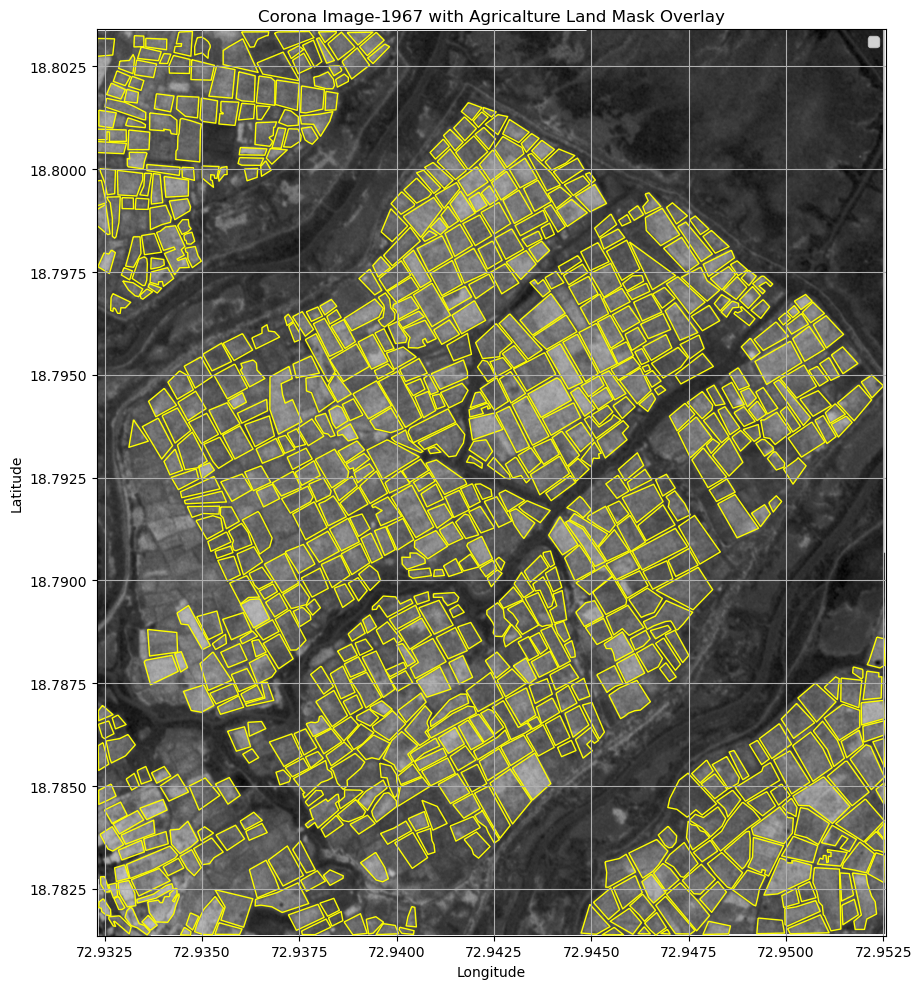

In [13]:
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
from shapely.geometry import box
import numpy as np

# === Input paths ===
raster_path = r"E:\Corona\Crop_Extraction\Data.tif"
shapefile_path = r"E:\Corona\Crop_Extraction\Mask.shp"

# === Load single-band raster ===
with rasterio.open(raster_path) as src:
    raster_crs = src.crs
    raster_bounds = src.bounds
    transform = src.transform
    band_count = src.count

    print(f"\n✅ Image Dimensions: {src.width} x {src.height} pixels")
    print(f"✅ Number of Bands: {band_count}")
    print(f"✅ Data Type: {src.dtypes[0]}")

    band = src.read(1).astype(np.float32)  # shape: (H, W)
    height, width = band.shape

    # === Print band statistics ===
    print(f"\n📊 Band stats:")
    print(f"  - Min:   {band.min():.4f}")
    print(f"  - Max:   {band.max():.4f}")
    print(f"  - Mean:  {band.mean():.4f}")
    print(f"  - Std:   {band.std():.4f}")

    # === Normalize to 0–1 for display
    min_val, max_val = band.min(), band.max()
    if max_val > min_val:
        band_norm = (band - min_val) / (max_val - min_val + 1e-6)
    else:
        band_norm = band

# === Load shapefile ===
mask_gdf = gpd.read_file(shapefile_path)

# === Reproject if CRS mismatch ===
if mask_gdf.crs != raster_crs:
    print("\n⚠️ CRS mismatch. Reprojecting shapefile to match raster...")
    mask_gdf = mask_gdf.to_crs(raster_crs)

# === Check for intersection ===
raster_box = box(*raster_bounds)
intersects = mask_gdf.intersects(raster_box).any()

print(f"\n🌍 Raster CRS: {raster_crs}")
print(f"🗺️ Shapefile CRS: {mask_gdf.crs}")
print(f"🔍 Do they intersect? {'✅ Yes' if intersects else '❌ No'}")

# === Plot grayscale image with shapefile overlay ===
extent = [raster_bounds.left, raster_bounds.right, raster_bounds.bottom, raster_bounds.top]

fig, ax = plt.subplots(figsize=(10, 10))
img = ax.imshow(band_norm, cmap='gray', extent=extent, vmin=0, vmax=1)

# Plot shapefile
if mask_gdf.geom_type.iloc[0] in ['Point', 'MultiPoint']:
    mask_gdf.plot(ax=ax, color='yellow', markersize=40, label='Points')
else:
    mask_gdf.plot(ax=ax, facecolor='none', edgecolor='yellow', linewidth=1, label='Mask')

ax.set_title("Corona Image-1967 with Agricalture Land Mask Overlay")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
import torch
print(torch.__version__)
print("CUDA Available:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU found")

2.5.1+cu121
CUDA Available: True
GPU: NVIDIA GeForce GTX 1650


In [31]:
import os
import numpy as np
import torch
import rasterio
from rasterio.windows import Window
from rasterio.features import rasterize
import fiona
import cv2
from shapely.geometry import shape
from tqdm import tqdm

# --- Configuration ---
IMAGE_PATH = r"E:\Corona\Crop_Extraction\Data.tif"
VECTOR_MASK_PATH = r"E:\Corona\Crop_Extraction\Mask.shp"
PATCH_OUTPUT_DIR = r"E:\Corona\Crop_Extraction\patches"

PATCH_SIZE = 128
STRIDE = 64
NUM_CLASSES = 2 

os.makedirs(os.path.join(PATCH_OUTPUT_DIR, "images"), exist_ok=True)
os.makedirs(os.path.join(PATCH_OUTPUT_DIR, "masks"), exist_ok=True)

# --- Step 1: Convert Shapefile/GeoJSON to rasterized binary instance masks ---
def create_instance_masks_from_vector(vector_path, image_src):
    with fiona.open(vector_path, "r") as shapefile:
        shapes = [feature["geometry"] for feature in shapefile]

    # Rasterize shapefile to single binary mask
    semantic_mask = rasterize(
        shapes=shapes,
        out_shape=(image_src.height, image_src.width),
        transform=image_src.transform,
        fill=0,
        default_value=255,
        dtype=np.uint8
    )

    # Find individual instances using contours
    contours, _ = cv2.findContours(semantic_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    masks = []
    boxes = []
    for contour in contours:
        instance_mask = np.zeros_like(semantic_mask, dtype=np.uint8)
        cv2.drawContours(instance_mask, [contour], -1, color=1, thickness=cv2.FILLED)
        masks.append(instance_mask)

        x, y, w, h = cv2.boundingRect(contour)
        boxes.append([x, y, x + w, y + h])

    if not masks:
        return np.empty((0, semantic_mask.shape[0], semantic_mask.shape[1]), dtype=np.uint8), np.empty((0, 4))
    
    return np.array(masks), np.array(boxes)

# --- Step 2: Extract patches and save if valid mask is present ---
def extract_and_save_patches(image_path, instance_masks, instance_boxes, patch_size, stride, out_dir):
    with rasterio.open(image_path) as src:
        width = src.width
        height = src.height
        transform = src.transform
        meta = src.meta.copy()

        patch_id = 0
        for top in tqdm(range(0, height - patch_size + 1, stride), desc="Extracting Patches"):
            for left in range(0, width - patch_size + 1, stride):
                window = Window(left, top, patch_size, patch_size)
                patch_transform = rasterio.windows.transform(window, transform)
                image_patch = src.read(window=window)

                local_masks = []
                for mask, box in zip(instance_masks, instance_boxes):
                    x_min, y_min, x_max, y_max = box
                    if (x_max <= left or x_min >= left + patch_size or
                        y_max <= top or y_min >= top + patch_size):
                        continue

                    patch_mask = mask[top:top+patch_size, left:left+patch_size]
                    if patch_mask.max() == 0:
                        continue

                    local_masks.append(patch_mask)

                if local_masks:
                    # Save image patch
                    patch_img_path = os.path.join(out_dir, "images", f"image_{patch_id:04d}.tif")
                    meta.update({
                        "height": patch_size,
                        "width": patch_size,
                        "transform": patch_transform
                    })
                    with rasterio.open(patch_img_path, 'w', **meta) as dst:
                        dst.write(image_patch)

                    # Save merged binary mask
                    merged_mask = np.zeros((patch_size, patch_size), dtype=np.uint8)
                    for m in local_masks:
                        merged_mask = np.logical_or(merged_mask, m).astype(np.uint8)

                    patch_mask_path = os.path.join(out_dir, "masks", f"mask_{patch_id:04d}.tif")
                    mask_meta = meta.copy()
                    mask_meta.update({
                        "count": 1,
                        "dtype": 'uint8',
                        "transform": patch_transform
                    })
                    mask_meta.pop("nodata", None)

                    with rasterio.open(patch_mask_path, 'w', **mask_meta) as dst:
                        dst.write(merged_mask, 1)

                    patch_id += 1

        print(f"\n✅ Total valid patches saved: {patch_id}")

# --- Run Pipeline ---
print("\n--- 🔍 Loading image and generating instance masks ---")
with rasterio.open(IMAGE_PATH) as src:
    print(f"📏 Image loaded: {src.width} x {src.height} | Bands: {src.count}")
    instance_masks, instance_boxes = create_instance_masks_from_vector(VECTOR_MASK_PATH, src)

print(f"🟩 Total instance masks found: {len(instance_masks)}")

extract_and_save_patches(
    IMAGE_PATH,
    instance_masks,
    instance_boxes,
    PATCH_SIZE,
    STRIDE,
    PATCH_OUTPUT_DIR
)


--- 🔍 Loading image and generating instance masks ---
📏 Image loaded: 909 x 989 | Bands: 1
🟩 Total instance masks found: 725


Extracting Patches: 100%|██████████████████████████████████████████████████████████████| 14/14 [00:16<00:00,  1.19s/it]


✅ Total valid patches saved: 175


In [47]:
import os
import glob
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score
from torch.utils.data import Dataset, DataLoader
import seaborn as sns

sns.set(style="whitegrid")

# ---------- Directories ----------
IMAGE_DIR = r"E:/Corona/Crop_Extraction/patches/images"
MASK_DIR = r"E:/Corona/Crop_Extraction/patches/masks"
GRAPH_DIR = r"E:/Corona/Crop_Extraction/graph"
MODEL_PATH = r"E:/Corona/Crop_Extraction/best_model.pth"
PRED_VIS_DIR = r"E:/Corona/Crop_Extraction/predictions"

os.makedirs(GRAPH_DIR, exist_ok=True)
os.makedirs(PRED_VIS_DIR, exist_ok=True)

# ---------- Device & Hyperparameters ----------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 8
NUM_EPOCHS = 500
LEARNING_RATE = 1e-4
IMG_SIZE = 128


# ---------- U-Net ----------
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()

        def conv_block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, 3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
            )

        self.encoder1 = conv_block(in_channels, 64)
        self.encoder2 = conv_block(64, 128)
        self.encoder3 = conv_block(128, 256)
        self.encoder4 = conv_block(256, 512)

        self.pool = nn.MaxPool2d(2)
        self.bottleneck = conv_block(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.decoder4 = conv_block(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.decoder3 = conv_block(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.decoder2 = conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.decoder1 = conv_block(128, 64)

        self.final = nn.Conv2d(64, out_channels, 1)

    def forward(self, x):
        e1 = self.encoder1(x)
        e2 = self.encoder2(self.pool(e1))
        e3 = self.encoder3(self.pool(e2))
        e4 = self.encoder4(self.pool(e3))
        b = self.bottleneck(self.pool(e4))
        d4 = self.upconv4(b)
        d4 = self.decoder4(torch.cat([d4, e4], dim=1))
        d3 = self.upconv3(d4)
        d3 = self.decoder3(torch.cat([d3, e3], dim=1))
        d2 = self.upconv2(d3)
        d2 = self.decoder2(torch.cat([d2, e2], dim=1))
        d1 = self.upconv1(d2)
        d1 = self.decoder1(torch.cat([d1, e1], dim=1))
        return self.final(d1)


# ---------- Dataset ----------
class SegDataset(Dataset):
    def __init__(self, image_paths, mask_paths):
        self.image_paths = image_paths
        self.mask_paths = mask_paths

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        with rasterio.open(self.image_paths[idx]) as src:
            image = src.read(1).astype(np.float32) / 255.0
        with rasterio.open(self.mask_paths[idx]) as src:
            mask = src.read(1).astype(np.float32)
        return torch.tensor(image).unsqueeze(0), torch.tensor(mask).unsqueeze(0)


# ---------- Loss ----------
def dice_loss(pred, target, smooth=1.):
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    return 1 - ((2. * intersection + smooth) / (pred.sum() + target.sum() + smooth))


class BCEDiceLoss(nn.Module):
    def __init__(self, pos_weight=20.0):
        super().__init__()
        self.register_buffer("pos_weight", torch.tensor(pos_weight))

    def forward(self, pred, target):
        bce = nn.BCEWithLogitsLoss(pos_weight=self.pos_weight)
        return bce(pred, target) + dice_loss(torch.sigmoid(pred), target)


# ---------- Metrics ----------
def compute_metrics(preds, targets):
    preds = (preds > 0.5).float()
    iou = (preds * targets).sum() / ((preds + targets).clamp(0, 1).sum() + 1e-6)
    f1 = f1_score(targets.view(-1).cpu(), preds.view(-1).cpu(), zero_division=0)
    precision = precision_score(targets.view(-1).cpu(), preds.view(-1).cpu(), zero_division=0)
    recall = recall_score(targets.view(-1).cpu(), preds.view(-1).cpu(), zero_division=0)
    return iou.item(), f1, precision, recall


# ---------- Save Predictions ----------
def save_predictions(images, masks, preds, epoch, save_dir, max_samples=5):
    images = images.cpu().numpy()
    masks = masks.cpu().numpy()
    preds = (preds > 0.5).float().cpu().numpy()
    for i in range(min(max_samples, images.shape[0])):
        fig, axes = plt.subplots(1, 3, figsize=(14, 4))
        axes[0].imshow(images[i][0], cmap='gray')
        axes[0].set_title("Input Image")
        axes[1].imshow(masks[i][0], cmap='gray')
        axes[1].set_title("Ground Truth")
        axes[2].imshow(preds[i][0], cmap='gray')
        axes[2].set_title("Prediction")
        for ax in axes:
            ax.axis('off')
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, f"epoch_{epoch}_sample_{i}.png"))
        plt.close()


# ---------- Training ----------
def train():
    image_paths = sorted(glob.glob(os.path.join(IMAGE_DIR, "*.tif")))
    mask_paths = sorted(glob.glob(os.path.join(MASK_DIR, "*.tif")))

    train_imgs, val_imgs, train_masks, val_masks = train_test_split(image_paths, mask_paths, test_size=0.3, random_state=42)
    train_ds = SegDataset(train_imgs, train_masks)
    val_ds = SegDataset(val_imgs, val_masks)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

    model = UNet().to(DEVICE)
    criterion = BCEDiceLoss()
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

    best_iou = 0
    train_losses, val_ious, val_f1s, val_precisions, val_recalls = [], [], [], [], []

    for epoch in range(1, NUM_EPOCHS + 1):
        model.train()
        epoch_loss = 0
        pbar = tqdm(train_loader, desc=f"[Epoch {epoch}/{NUM_EPOCHS}]", ncols=100)
        for images, masks in pbar:
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            preds = model(images)
            loss = criterion(preds, masks)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            pbar.set_postfix(loss=loss.item())

        train_losses.append(epoch_loss / len(train_loader))

        # Validation
        model.eval()
        all_preds, all_targets = [], []
        with torch.no_grad():
            for images, masks in tqdm(val_loader, desc="Validating", leave=False):
                images, masks = images.to(DEVICE), masks.to(DEVICE)
                preds = model(images)
                all_preds.append(torch.sigmoid(preds))
                all_targets.append(masks)

        all_preds = torch.cat(all_preds)
        all_targets = torch.cat(all_targets)
        iou, f1, precision, recall = compute_metrics(all_preds, all_targets)

        print(f"📊 Val IoU: {iou:.4f} | F1: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")
        val_ious.append(iou)
        val_f1s.append(f1)
        val_precisions.append(precision)
        val_recalls.append(recall)

        save_predictions(images, masks, torch.sigmoid(preds), epoch, PRED_VIS_DIR)

        if iou > best_iou:
            best_iou = iou
            torch.save(model.state_dict(), MODEL_PATH)
            print(f"✅ Saved best model at epoch {epoch} with IoU {iou:.4f}")

        torch.cuda.empty_cache()

    # ---------- Save Enhanced Graphs ----------
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label="Train Loss", color='red', linewidth=2, marker='o')
    plt.title("Training Loss", fontsize=14)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("BCE + Dice Loss", fontsize=12)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(GRAPH_DIR, "train_loss.png"), dpi=1200)
    plt.close()

    plt.figure(figsize=(8, 5))
    plt.plot(val_ious, label="Validation IoU", color='green', linewidth=2, marker='s')
    plt.title("Validation IoU", fontsize=14)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("IoU", fontsize=12)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(GRAPH_DIR, "val_iou.png"), dpi=1200)
    plt.close()

    plt.figure(figsize=(8, 5))
    plt.plot(val_f1s, label="F1 Score", color='blue', linewidth=2, marker='^')
    plt.plot(val_precisions, label="Precision", color='orange', linewidth=2, marker='x')
    plt.plot(val_recalls, label="Recall", color='purple', linewidth=2, marker='d')
    plt.title("Validation Metrics", fontsize=14)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Score", fontsize=12)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(GRAPH_DIR, "val_metrics.png"), dpi=1200)
    plt.close()



if __name__ == "__main__":
    train()


[Epoch 1/500]: 100%|██████████████████████████████████████| 16/16 [00:05<00:00,  3.20it/s, loss=3.1]


📊 Val IoU: 0.4678 | F1: 0.6374 | Precision: 0.4680 | Recall: 0.9992
✅ Saved best model at epoch 1 with IoU 0.4678


[Epoch 2/500]: 100%|█████████████████████████████████████| 16/16 [00:04<00:00,  3.23it/s, loss=7.47]


📊 Val IoU: 0.5471 | F1: 0.7072 | Precision: 0.5478 | Recall: 0.9977
✅ Saved best model at epoch 2 with IoU 0.5471


[Epoch 3/500]: 100%|█████████████████████████████████████| 16/16 [00:04<00:00,  3.28it/s, loss=6.25]


📊 Val IoU: 0.6259 | F1: 0.7699 | Precision: 0.6282 | Recall: 0.9941
✅ Saved best model at epoch 3 with IoU 0.6259


[Epoch 4/500]: 100%|█████████████████████████████████████| 16/16 [00:04<00:00,  3.29it/s, loss=2.02]


📊 Val IoU: 0.6460 | F1: 0.7850 | Precision: 0.6491 | Recall: 0.9929
✅ Saved best model at epoch 4 with IoU 0.6460


[Epoch 5/500]: 100%|█████████████████████████████████████| 16/16 [00:04<00:00,  3.28it/s, loss=5.35]


📊 Val IoU: 0.6719 | F1: 0.8037 | Precision: 0.6773 | Recall: 0.9883
✅ Saved best model at epoch 5 with IoU 0.6719


[Epoch 6/500]: 100%|██████████████████████████████████████| 16/16 [00:04<00:00,  3.35it/s, loss=3.4]


📊 Val IoU: 0.6688 | F1: 0.8015 | Precision: 0.6733 | Recall: 0.9901


[Epoch 7/500]: 100%|█████████████████████████████████████| 16/16 [00:05<00:00,  3.17it/s, loss=1.66]


📊 Val IoU: 0.6476 | F1: 0.7861 | Precision: 0.6495 | Recall: 0.9955


[Epoch 8/500]: 100%|█████████████████████████████████████| 16/16 [00:05<00:00,  3.16it/s, loss=1.86]


📊 Val IoU: 0.6366 | F1: 0.7780 | Precision: 0.6377 | Recall: 0.9972


[Epoch 9/500]: 100%|██████████████████████████████████████| 16/16 [00:05<00:00,  2.72it/s, loss=1.7]


📊 Val IoU: 0.6526 | F1: 0.7898 | Precision: 0.6541 | Recall: 0.9965


[Epoch 10/500]: 100%|████████████████████████████████████| 16/16 [00:04<00:00,  3.27it/s, loss=3.32]


📊 Val IoU: 0.6721 | F1: 0.8039 | Precision: 0.6754 | Recall: 0.9927
✅ Saved best model at epoch 10 with IoU 0.6721


[Epoch 11/500]: 100%|████████████████████████████████████| 16/16 [00:04<00:00,  3.24it/s, loss=2.31]


📊 Val IoU: 0.6581 | F1: 0.7938 | Precision: 0.6595 | Recall: 0.9967


[Epoch 12/500]: 100%|████████████████████████████████████| 16/16 [00:04<00:00,  3.40it/s, loss=1.62]


📊 Val IoU: 0.6657 | F1: 0.7993 | Precision: 0.6675 | Recall: 0.9961


[Epoch 13/500]: 100%|████████████████████████████████████| 16/16 [00:04<00:00,  3.44it/s, loss=1.67]


📊 Val IoU: 0.6539 | F1: 0.7907 | Precision: 0.6549 | Recall: 0.9977


[Epoch 14/500]: 100%|████████████████████████████████████| 16/16 [00:05<00:00,  3.18it/s, loss=5.55]


📊 Val IoU: 0.7186 | F1: 0.8363 | Precision: 0.7408 | Recall: 0.9600
✅ Saved best model at epoch 14 with IoU 0.7186


[Epoch 15/500]: 100%|████████████████████████████████████| 16/16 [00:04<00:00,  3.43it/s, loss=1.52]


📊 Val IoU: 0.6616 | F1: 0.7963 | Precision: 0.6638 | Recall: 0.9950


[Epoch 16/500]: 100%|████████████████████████████████████| 16/16 [00:05<00:00,  3.17it/s, loss=1.74]


📊 Val IoU: 0.6519 | F1: 0.7893 | Precision: 0.6529 | Recall: 0.9978


[Epoch 17/500]: 100%|████████████████████████████████████| 16/16 [00:05<00:00,  3.06it/s, loss=3.63]


📊 Val IoU: 0.6702 | F1: 0.8026 | Precision: 0.6731 | Recall: 0.9936


[Epoch 18/500]: 100%|████████████████████████████████████| 16/16 [00:04<00:00,  3.47it/s, loss=2.66]


📊 Val IoU: 0.6856 | F1: 0.8135 | Precision: 0.6889 | Recall: 0.9932


[Epoch 19/500]: 100%|████████████████████████████████████| 16/16 [00:05<00:00,  3.07it/s, loss=2.49]


📊 Val IoU: 0.6880 | F1: 0.8152 | Precision: 0.6900 | Recall: 0.9957


[Epoch 20/500]: 100%|████████████████████████████████████| 16/16 [00:04<00:00,  3.42it/s, loss=1.74]


📊 Val IoU: 0.6959 | F1: 0.8207 | Precision: 0.6980 | Recall: 0.9957


[Epoch 21/500]: 100%|████████████████████████████████████| 16/16 [00:05<00:00,  3.18it/s, loss=1.27]


📊 Val IoU: 0.6769 | F1: 0.8073 | Precision: 0.6775 | Recall: 0.9987


[Epoch 22/500]: 100%|████████████████████████████████████| 16/16 [00:05<00:00,  3.07it/s, loss=1.15]


📊 Val IoU: 0.7169 | F1: 0.8351 | Precision: 0.7195 | Recall: 0.9951


[Epoch 23/500]: 100%|█████████████████████████████████████| 16/16 [00:04<00:00,  3.44it/s, loss=3.3]


📊 Val IoU: 0.6863 | F1: 0.8140 | Precision: 0.6877 | Recall: 0.9970


[Epoch 24/500]: 100%|████████████████████████████████████| 16/16 [00:04<00:00,  3.35it/s, loss=1.34]


📊 Val IoU: 0.7466 | F1: 0.8549 | Precision: 0.7545 | Recall: 0.9862
✅ Saved best model at epoch 24 with IoU 0.7466


[Epoch 25/500]: 100%|████████████████████████████████████| 16/16 [00:05<00:00,  2.70it/s, loss=1.36]


📊 Val IoU: 0.7039 | F1: 0.8262 | Precision: 0.7053 | Recall: 0.9972


[Epoch 26/500]: 100%|████████████████████████████████████| 16/16 [00:05<00:00,  3.09it/s, loss=2.03]


📊 Val IoU: 0.7339 | F1: 0.8465 | Precision: 0.7397 | Recall: 0.9893


[Epoch 27/500]: 100%|████████████████████████████████████| 16/16 [00:05<00:00,  3.01it/s, loss=2.16]


📊 Val IoU: 0.6823 | F1: 0.8112 | Precision: 0.6830 | Recall: 0.9985


[Epoch 28/500]: 100%|████████████████████████████████████| 16/16 [00:05<00:00,  3.12it/s, loss=7.36]


📊 Val IoU: 0.7731 | F1: 0.8720 | Precision: 0.7793 | Recall: 0.9898
✅ Saved best model at epoch 28 with IoU 0.7731


[Epoch 29/500]: 100%|████████████████████████████████████| 16/16 [00:05<00:00,  2.91it/s, loss=4.76]


📊 Val IoU: 0.7378 | F1: 0.8491 | Precision: 0.7435 | Recall: 0.9898


[Epoch 30/500]: 100%|████████████████████████████████████| 16/16 [00:05<00:00,  3.12it/s, loss=1.77]


📊 Val IoU: 0.6728 | F1: 0.8044 | Precision: 0.6736 | Recall: 0.9982


[Epoch 31/500]: 100%|████████████████████████████████████| 16/16 [00:05<00:00,  3.10it/s, loss=1.43]


📊 Val IoU: 0.7290 | F1: 0.8433 | Precision: 0.7311 | Recall: 0.9961


[Epoch 32/500]: 100%|███████████████████████████████████| 16/16 [00:04<00:00,  3.21it/s, loss=0.936]


📊 Val IoU: 0.7418 | F1: 0.8517 | Precision: 0.7448 | Recall: 0.9946


[Epoch 33/500]: 100%|█████████████████████████████████████| 16/16 [00:04<00:00,  3.38it/s, loss=1.2]


📊 Val IoU: 0.7725 | F1: 0.8717 | Precision: 0.7775 | Recall: 0.9918


[Epoch 34/500]: 100%|████████████████████████████████████| 16/16 [00:05<00:00,  3.11it/s, loss=1.23]


📊 Val IoU: 0.7564 | F1: 0.8613 | Precision: 0.7591 | Recall: 0.9953


[Epoch 35/500]: 100%|████████████████████████████████████| 16/16 [00:06<00:00,  2.64it/s, loss=2.32]


📊 Val IoU: 0.7860 | F1: 0.8802 | Precision: 0.7901 | Recall: 0.9935
✅ Saved best model at epoch 35 with IoU 0.7860


[Epoch 36/500]: 100%|████████████████████████████████████| 16/16 [00:04<00:00,  3.30it/s, loss=1.42]


📊 Val IoU: 0.7629 | F1: 0.8655 | Precision: 0.7657 | Recall: 0.9952


[Epoch 37/500]: 100%|████████████████████████████████████| 16/16 [00:05<00:00,  2.79it/s, loss=0.82]


📊 Val IoU: 0.7892 | F1: 0.8822 | Precision: 0.7940 | Recall: 0.9923
✅ Saved best model at epoch 37 with IoU 0.7892


[Epoch 38/500]: 100%|████████████████████████████████████| 16/16 [00:06<00:00,  2.58it/s, loss=2.14]


📊 Val IoU: 0.8311 | F1: 0.9078 | Precision: 0.8432 | Recall: 0.9830
✅ Saved best model at epoch 38 with IoU 0.8311


[Epoch 39/500]: 100%|████████████████████████████████████| 16/16 [00:04<00:00,  3.24it/s, loss=2.66]


📊 Val IoU: 0.7591 | F1: 0.8630 | Precision: 0.7631 | Recall: 0.9931


[Epoch 40/500]: 100%|████████████████████████████████████| 16/16 [00:05<00:00,  2.94it/s, loss=1.12]


📊 Val IoU: 0.7405 | F1: 0.8509 | Precision: 0.7454 | Recall: 0.9913


[Epoch 41/500]: 100%|███████████████████████████████████| 16/16 [00:05<00:00,  3.20it/s, loss=0.848]


📊 Val IoU: 0.7250 | F1: 0.8406 | Precision: 0.7262 | Recall: 0.9977


[Epoch 42/500]: 100%|████████████████████████████████████| 16/16 [00:05<00:00,  3.04it/s, loss=2.24]


📊 Val IoU: 0.7487 | F1: 0.8563 | Precision: 0.7506 | Recall: 0.9967


[Epoch 43/500]: 100%|███████████████████████████████████| 16/16 [00:05<00:00,  3.11it/s, loss=0.733]


📊 Val IoU: 0.7933 | F1: 0.8847 | Precision: 0.7974 | Recall: 0.9936


[Epoch 44/500]: 100%|████████████████████████████████████| 16/16 [00:04<00:00,  3.23it/s, loss=1.79]


📊 Val IoU: 0.8232 | F1: 0.9030 | Precision: 0.8294 | Recall: 0.9909


[Epoch 45/500]: 100%|████████████████████████████████████| 16/16 [00:04<00:00,  3.40it/s, loss=1.35]


📊 Val IoU: 0.7997 | F1: 0.8887 | Precision: 0.8040 | Recall: 0.9933


[Epoch 46/500]: 100%|███████████████████████████████████| 16/16 [00:05<00:00,  3.11it/s, loss=0.838]


📊 Val IoU: 0.8085 | F1: 0.8941 | Precision: 0.8118 | Recall: 0.9950


[Epoch 47/500]: 100%|████████████████████████████████████| 16/16 [00:04<00:00,  3.38it/s, loss=2.62]


📊 Val IoU: 0.8342 | F1: 0.9096 | Precision: 0.8402 | Recall: 0.9916
✅ Saved best model at epoch 47 with IoU 0.8342


[Epoch 48/500]: 100%|████████████████████████████████████| 16/16 [00:05<00:00,  3.14it/s, loss=2.36]


📊 Val IoU: 0.8003 | F1: 0.8891 | Precision: 0.8072 | Recall: 0.9895


[Epoch 49/500]: 100%|███████████████████████████████████████| 16/16 [00:04<00:00,  3.38it/s, loss=3]


📊 Val IoU: 0.8347 | F1: 0.9099 | Precision: 0.8559 | Recall: 0.9712
✅ Saved best model at epoch 49 with IoU 0.8347


[Epoch 50/500]: 100%|███████████████████████████████████| 16/16 [00:05<00:00,  3.17it/s, loss=0.795]


📊 Val IoU: 0.7461 | F1: 0.8546 | Precision: 0.7481 | Recall: 0.9965


[Epoch 51/500]: 100%|███████████████████████████████████| 16/16 [00:05<00:00,  3.09it/s, loss=0.631]


📊 Val IoU: 0.7793 | F1: 0.8760 | Precision: 0.7815 | Recall: 0.9964


[Epoch 52/500]: 100%|███████████████████████████████████| 16/16 [00:04<00:00,  3.24it/s, loss=0.776]


📊 Val IoU: 0.8188 | F1: 0.9004 | Precision: 0.8244 | Recall: 0.9917


[Epoch 53/500]: 100%|███████████████████████████████████████| 16/16 [00:05<00:00,  3.07it/s, loss=1]


📊 Val IoU: 0.8111 | F1: 0.8957 | Precision: 0.8140 | Recall: 0.9956


[Epoch 54/500]: 100%|███████████████████████████████████| 16/16 [00:04<00:00,  3.37it/s, loss=0.822]


📊 Val IoU: 0.8480 | F1: 0.9178 | Precision: 0.8587 | Recall: 0.9855
✅ Saved best model at epoch 54 with IoU 0.8480


[Epoch 55/500]: 100%|███████████████████████████████████| 16/16 [00:05<00:00,  3.02it/s, loss=0.596]


📊 Val IoU: 0.8330 | F1: 0.9089 | Precision: 0.8386 | Recall: 0.9921


[Epoch 56/500]: 100%|███████████████████████████████████| 16/16 [00:04<00:00,  3.42it/s, loss=0.739]


📊 Val IoU: 0.8336 | F1: 0.9093 | Precision: 0.8377 | Recall: 0.9943


[Epoch 57/500]: 100%|███████████████████████████████████| 16/16 [00:04<00:00,  3.33it/s, loss=0.508]


📊 Val IoU: 0.8335 | F1: 0.9092 | Precision: 0.8379 | Recall: 0.9937


[Epoch 58/500]: 100%|███████████████████████████████████| 16/16 [00:05<00:00,  3.02it/s, loss=0.552]


📊 Val IoU: 0.8245 | F1: 0.9038 | Precision: 0.8271 | Recall: 0.9961


[Epoch 59/500]: 100%|███████████████████████████████████| 16/16 [00:04<00:00,  3.38it/s, loss=0.758]


📊 Val IoU: 0.8614 | F1: 0.9255 | Precision: 0.8688 | Recall: 0.9903
✅ Saved best model at epoch 59 with IoU 0.8614


[Epoch 60/500]: 100%|███████████████████████████████████| 16/16 [00:05<00:00,  2.91it/s, loss=0.646]


📊 Val IoU: 0.8616 | F1: 0.9257 | Precision: 0.8690 | Recall: 0.9902
✅ Saved best model at epoch 60 with IoU 0.8616


[Epoch 61/500]: 100%|███████████████████████████████████| 16/16 [00:05<00:00,  3.17it/s, loss=0.604]


📊 Val IoU: 0.8645 | F1: 0.9273 | Precision: 0.8694 | Recall: 0.9935
✅ Saved best model at epoch 61 with IoU 0.8645


[Epoch 62/500]: 100%|███████████████████████████████████| 16/16 [00:04<00:00,  3.33it/s, loss=0.458]


📊 Val IoU: 0.8759 | F1: 0.9338 | Precision: 0.8841 | Recall: 0.9895
✅ Saved best model at epoch 62 with IoU 0.8759


[Epoch 63/500]: 100%|███████████████████████████████████| 16/16 [00:04<00:00,  3.26it/s, loss=0.629]


📊 Val IoU: 0.8650 | F1: 0.9276 | Precision: 0.8695 | Recall: 0.9940


[Epoch 64/500]: 100%|████████████████████████████████████| 16/16 [00:04<00:00,  3.44it/s, loss=1.11]


📊 Val IoU: 0.8598 | F1: 0.9246 | Precision: 0.8637 | Recall: 0.9948


[Epoch 65/500]: 100%|████████████████████████████████████| 16/16 [00:04<00:00,  3.22it/s, loss=0.52]


📊 Val IoU: 0.8695 | F1: 0.9302 | Precision: 0.8733 | Recall: 0.9949


[Epoch 66/500]: 100%|█████████████████████████████████████| 16/16 [00:04<00:00,  3.36it/s, loss=0.5]


📊 Val IoU: 0.8868 | F1: 0.9400 | Precision: 0.8944 | Recall: 0.9905
✅ Saved best model at epoch 66 with IoU 0.8868


[Epoch 67/500]: 100%|███████████████████████████████████| 16/16 [00:05<00:00,  3.08it/s, loss=0.408]


📊 Val IoU: 0.8855 | F1: 0.9393 | Precision: 0.8926 | Recall: 0.9911


[Epoch 68/500]: 100%|███████████████████████████████████| 16/16 [00:05<00:00,  3.08it/s, loss=0.542]


📊 Val IoU: 0.8917 | F1: 0.9428 | Precision: 0.8990 | Recall: 0.9910
✅ Saved best model at epoch 68 with IoU 0.8917


[Epoch 69/500]: 100%|███████████████████████████████████| 16/16 [00:05<00:00,  3.04it/s, loss=0.447]


📊 Val IoU: 0.8930 | F1: 0.9435 | Precision: 0.8997 | Recall: 0.9917
✅ Saved best model at epoch 69 with IoU 0.8930


[Epoch 70/500]: 100%|███████████████████████████████████| 16/16 [00:08<00:00,  1.94it/s, loss=0.704]


📊 Val IoU: 0.8729 | F1: 0.9322 | Precision: 0.8776 | Recall: 0.9940


[Epoch 71/500]: 100%|███████████████████████████████████| 16/16 [00:04<00:00,  3.32it/s, loss=0.376]


📊 Val IoU: 0.8862 | F1: 0.9397 | Precision: 0.8935 | Recall: 0.9909


[Epoch 72/500]: 100%|███████████████████████████████████| 16/16 [00:04<00:00,  3.42it/s, loss=0.567]


📊 Val IoU: 0.8770 | F1: 0.9345 | Precision: 0.8811 | Recall: 0.9947


[Epoch 73/500]: 100%|███████████████████████████████████| 16/16 [00:05<00:00,  3.09it/s, loss=0.678]


📊 Val IoU: 0.8966 | F1: 0.9455 | Precision: 0.9025 | Recall: 0.9929
✅ Saved best model at epoch 73 with IoU 0.8966


[Epoch 74/500]: 100%|███████████████████████████████████| 16/16 [00:04<00:00,  3.26it/s, loss=0.342]


📊 Val IoU: 0.9059 | F1: 0.9506 | Precision: 0.9127 | Recall: 0.9918
✅ Saved best model at epoch 74 with IoU 0.9059


[Epoch 75/500]: 100%|█████████████████████████████████████| 16/16 [00:04<00:00,  3.23it/s, loss=1.2]


📊 Val IoU: 0.9047 | F1: 0.9500 | Precision: 0.9154 | Recall: 0.9873


[Epoch 76/500]: 100%|████████████████████████████████████| 16/16 [00:04<00:00,  3.37it/s, loss=2.26]


📊 Val IoU: 0.8776 | F1: 0.9348 | Precision: 0.8851 | Recall: 0.9905


[Epoch 77/500]: 100%|███████████████████████████████████| 16/16 [00:04<00:00,  3.30it/s, loss=0.452]


📊 Val IoU: 0.8424 | F1: 0.9145 | Precision: 0.8451 | Recall: 0.9963


[Epoch 78/500]: 100%|████████████████████████████████████| 16/16 [00:05<00:00,  3.06it/s, loss=1.46]


📊 Val IoU: 0.8903 | F1: 0.9420 | Precision: 0.8977 | Recall: 0.9908


[Epoch 79/500]: 100%|███████████████████████████████████| 16/16 [00:05<00:00,  2.75it/s, loss=0.791]


📊 Val IoU: 0.7638 | F1: 0.8661 | Precision: 0.7657 | Recall: 0.9968


[Epoch 80/500]: 100%|███████████████████████████████████| 16/16 [00:05<00:00,  2.85it/s, loss=0.656]


📊 Val IoU: 0.8447 | F1: 0.9158 | Precision: 0.8487 | Recall: 0.9944


[Epoch 81/500]: 100%|█████████████████████████████████████| 16/16 [00:05<00:00,  2.99it/s, loss=0.7]


📊 Val IoU: 0.8762 | F1: 0.9340 | Precision: 0.8814 | Recall: 0.9934


[Epoch 82/500]: 100%|████████████████████████████████████| 16/16 [00:05<00:00,  2.93it/s, loss=2.08]


📊 Val IoU: 0.8901 | F1: 0.9419 | Precision: 0.8971 | Recall: 0.9913


[Epoch 83/500]: 100%|███████████████████████████████████| 16/16 [00:06<00:00,  2.30it/s, loss=0.506]


📊 Val IoU: 0.8560 | F1: 0.9224 | Precision: 0.8640 | Recall: 0.9893


[Epoch 84/500]: 100%|███████████████████████████████████| 16/16 [00:05<00:00,  2.90it/s, loss=0.377]


📊 Val IoU: 0.8736 | F1: 0.9325 | Precision: 0.8789 | Recall: 0.9932


[Epoch 85/500]: 100%|███████████████████████████████████| 16/16 [00:05<00:00,  2.82it/s, loss=0.962]


📊 Val IoU: 0.8751 | F1: 0.9334 | Precision: 0.8791 | Recall: 0.9948


[Epoch 86/500]: 100%|███████████████████████████████████| 16/16 [00:05<00:00,  2.99it/s, loss=0.625]


📊 Val IoU: 0.9059 | F1: 0.9506 | Precision: 0.9145 | Recall: 0.9896
✅ Saved best model at epoch 86 with IoU 0.9059


[Epoch 87/500]: 100%|███████████████████████████████████| 16/16 [00:05<00:00,  2.82it/s, loss=0.337]


📊 Val IoU: 0.9062 | F1: 0.9508 | Precision: 0.9135 | Recall: 0.9913
✅ Saved best model at epoch 87 with IoU 0.9062


[Epoch 88/500]: 100%|████████████████████████████████████| 16/16 [00:05<00:00,  2.87it/s, loss=0.39]


📊 Val IoU: 0.9184 | F1: 0.9574 | Precision: 0.9271 | Recall: 0.9899
✅ Saved best model at epoch 88 with IoU 0.9184


[Epoch 89/500]: 100%|███████████████████████████████████| 16/16 [00:05<00:00,  3.03it/s, loss=0.298]


📊 Val IoU: 0.9156 | F1: 0.9559 | Precision: 0.9233 | Recall: 0.9910


[Epoch 90/500]: 100%|████████████████████████████████████| 16/16 [00:05<00:00,  3.06it/s, loss=0.25]


📊 Val IoU: 0.9173 | F1: 0.9569 | Precision: 0.9243 | Recall: 0.9918


[Epoch 91/500]: 100%|███████████████████████████████████| 16/16 [00:05<00:00,  2.95it/s, loss=0.334]


📊 Val IoU: 0.9092 | F1: 0.9524 | Precision: 0.9150 | Recall: 0.9931


[Epoch 92/500]: 100%|███████████████████████████████████| 16/16 [00:05<00:00,  3.01it/s, loss=0.363]


📊 Val IoU: 0.9192 | F1: 0.9579 | Precision: 0.9273 | Recall: 0.9905
✅ Saved best model at epoch 92 with IoU 0.9192


[Epoch 93/500]: 100%|████████████████████████████████████| 16/16 [00:05<00:00,  3.06it/s, loss=1.13]


📊 Val IoU: 0.9050 | F1: 0.9501 | Precision: 0.9103 | Recall: 0.9937


[Epoch 94/500]: 100%|███████████████████████████████████| 16/16 [00:05<00:00,  3.12it/s, loss=0.368]


📊 Val IoU: 0.8695 | F1: 0.9302 | Precision: 0.8743 | Recall: 0.9938


[Epoch 95/500]: 100%|████████████████████████████████████| 16/16 [00:05<00:00,  3.09it/s, loss=2.16]


📊 Val IoU: 0.8921 | F1: 0.9430 | Precision: 0.8974 | Recall: 0.9934


[Epoch 96/500]: 100%|███████████████████████████████████| 16/16 [00:05<00:00,  3.17it/s, loss=0.366]


📊 Val IoU: 0.9020 | F1: 0.9485 | Precision: 0.9074 | Recall: 0.9935


[Epoch 97/500]: 100%|███████████████████████████████████| 16/16 [00:05<00:00,  2.90it/s, loss=0.256]


📊 Val IoU: 0.9225 | F1: 0.9597 | Precision: 0.9311 | Recall: 0.9901
✅ Saved best model at epoch 97 with IoU 0.9225


[Epoch 98/500]: 100%|███████████████████████████████████| 16/16 [00:05<00:00,  3.08it/s, loss=0.295]


📊 Val IoU: 0.9210 | F1: 0.9589 | Precision: 0.9270 | Recall: 0.9931


[Epoch 99/500]: 100%|███████████████████████████████████| 16/16 [00:05<00:00,  2.98it/s, loss=0.346]


📊 Val IoU: 0.9157 | F1: 0.9560 | Precision: 0.9220 | Recall: 0.9927


[Epoch 100/500]: 100%|██████████████████████████████████| 16/16 [00:05<00:00,  3.02it/s, loss=0.239]


📊 Val IoU: 0.8935 | F1: 0.9438 | Precision: 0.8976 | Recall: 0.9949


[Epoch 101/500]: 100%|██████████████████████████████████| 16/16 [00:05<00:00,  2.99it/s, loss=0.205]


📊 Val IoU: 0.9293 | F1: 0.9634 | Precision: 0.9390 | Recall: 0.9890
✅ Saved best model at epoch 101 with IoU 0.9293


[Epoch 102/500]: 100%|███████████████████████████████████| 16/16 [00:05<00:00,  3.15it/s, loss=1.75]


📊 Val IoU: 0.9337 | F1: 0.9657 | Precision: 0.9498 | Recall: 0.9822
✅ Saved best model at epoch 102 with IoU 0.9337


[Epoch 103/500]: 100%|███████████████████████████████████| 16/16 [00:04<00:00,  3.22it/s, loss=0.45]


📊 Val IoU: 0.8460 | F1: 0.9166 | Precision: 0.8777 | Recall: 0.9591


[Epoch 104/500]: 100%|██████████████████████████████████| 16/16 [00:05<00:00,  2.95it/s, loss=0.485]


📊 Val IoU: 0.8604 | F1: 0.9250 | Precision: 0.8744 | Recall: 0.9817


[Epoch 105/500]: 100%|██████████████████████████████████| 16/16 [00:05<00:00,  3.08it/s, loss=0.501]


📊 Val IoU: 0.8576 | F1: 0.9233 | Precision: 0.8630 | Recall: 0.9926


[Epoch 106/500]: 100%|██████████████████████████████████| 16/16 [00:05<00:00,  3.11it/s, loss=0.591]


📊 Val IoU: 0.8911 | F1: 0.9424 | Precision: 0.8957 | Recall: 0.9943


[Epoch 107/500]: 100%|██████████████████████████████████| 16/16 [00:05<00:00,  3.02it/s, loss=0.391]


📊 Val IoU: 0.9072 | F1: 0.9513 | Precision: 0.9124 | Recall: 0.9937


[Epoch 108/500]: 100%|██████████████████████████████████| 16/16 [00:04<00:00,  3.39it/s, loss=0.881]


📊 Val IoU: 0.9057 | F1: 0.9505 | Precision: 0.9115 | Recall: 0.9930


[Epoch 109/500]: 100%|██████████████████████████████████| 16/16 [00:05<00:00,  3.16it/s, loss=0.384]


📊 Val IoU: 0.8997 | F1: 0.9472 | Precision: 0.9053 | Recall: 0.9932


[Epoch 110/500]: 100%|██████████████████████████████████| 16/16 [00:04<00:00,  3.23it/s, loss=0.211]


📊 Val IoU: 0.9114 | F1: 0.9536 | Precision: 0.9194 | Recall: 0.9905


[Epoch 111/500]: 100%|██████████████████████████████████| 16/16 [00:04<00:00,  3.31it/s, loss=0.204]


📊 Val IoU: 0.9262 | F1: 0.9617 | Precision: 0.9335 | Recall: 0.9917


[Epoch 112/500]: 100%|██████████████████████████████████| 16/16 [00:05<00:00,  2.99it/s, loss=0.184]


📊 Val IoU: 0.9330 | F1: 0.9653 | Precision: 0.9416 | Recall: 0.9902


[Epoch 113/500]: 100%|██████████████████████████████████| 16/16 [00:05<00:00,  3.08it/s, loss=0.343]


📊 Val IoU: 0.9333 | F1: 0.9655 | Precision: 0.9414 | Recall: 0.9908


[Epoch 114/500]: 100%|██████████████████████████████████| 16/16 [00:05<00:00,  2.90it/s, loss=0.208]


📊 Val IoU: 0.9390 | F1: 0.9685 | Precision: 0.9489 | Recall: 0.9890
✅ Saved best model at epoch 114 with IoU 0.9390


[Epoch 115/500]: 100%|██████████████████████████████████| 16/16 [00:05<00:00,  2.99it/s, loss=0.202]


📊 Val IoU: 0.9377 | F1: 0.9679 | Precision: 0.9457 | Recall: 0.9911


[Epoch 116/500]: 100%|██████████████████████████████████| 16/16 [00:04<00:00,  3.27it/s, loss=0.172]


📊 Val IoU: 0.9313 | F1: 0.9644 | Precision: 0.9388 | Recall: 0.9914


[Epoch 117/500]: 100%|██████████████████████████████████| 16/16 [00:05<00:00,  3.07it/s, loss=0.132]


📊 Val IoU: 0.9369 | F1: 0.9674 | Precision: 0.9454 | Recall: 0.9905


[Epoch 118/500]: 100%|██████████████████████████████████| 16/16 [00:05<00:00,  3.11it/s, loss=0.218]


📊 Val IoU: 0.9421 | F1: 0.9702 | Precision: 0.9523 | Recall: 0.9887
✅ Saved best model at epoch 118 with IoU 0.9421


[Epoch 119/500]: 100%|██████████████████████████████████| 16/16 [00:04<00:00,  3.27it/s, loss=0.334]


📊 Val IoU: 0.9300 | F1: 0.9637 | Precision: 0.9372 | Recall: 0.9919


[Epoch 120/500]: 100%|██████████████████████████████████| 16/16 [00:04<00:00,  3.29it/s, loss=0.168]


📊 Val IoU: 0.9417 | F1: 0.9700 | Precision: 0.9511 | Recall: 0.9896


[Epoch 121/500]: 100%|██████████████████████████████████| 16/16 [00:04<00:00,  3.35it/s, loss=0.142]


📊 Val IoU: 0.9420 | F1: 0.9701 | Precision: 0.9512 | Recall: 0.9898


[Epoch 122/500]: 100%|██████████████████████████████████| 16/16 [00:05<00:00,  2.95it/s, loss=0.582]


📊 Val IoU: 0.9343 | F1: 0.9660 | Precision: 0.9409 | Recall: 0.9925


[Epoch 123/500]: 100%|██████████████████████████████████| 16/16 [00:05<00:00,  2.91it/s, loss=0.384]


📊 Val IoU: 0.9192 | F1: 0.9579 | Precision: 0.9358 | Recall: 0.9810


[Epoch 124/500]: 100%|██████████████████████████████████| 16/16 [00:04<00:00,  3.39it/s, loss=0.213]


📊 Val IoU: 0.9025 | F1: 0.9488 | Precision: 0.9088 | Recall: 0.9924


[Epoch 125/500]: 100%|██████████████████████████████████| 16/16 [00:04<00:00,  3.25it/s, loss=0.173]


📊 Val IoU: 0.9230 | F1: 0.9599 | Precision: 0.9306 | Recall: 0.9912


[Epoch 126/500]: 100%|██████████████████████████████████| 16/16 [00:04<00:00,  3.42it/s, loss=0.527]


📊 Val IoU: 0.9238 | F1: 0.9604 | Precision: 0.9313 | Recall: 0.9914


[Epoch 127/500]: 100%|██████████████████████████████████| 16/16 [00:04<00:00,  3.31it/s, loss=0.504]


📊 Val IoU: 0.9309 | F1: 0.9642 | Precision: 0.9392 | Recall: 0.9906


[Epoch 128/500]: 100%|██████████████████████████████████| 16/16 [00:04<00:00,  3.21it/s, loss=0.165]


📊 Val IoU: 0.9263 | F1: 0.9617 | Precision: 0.9344 | Recall: 0.9907


[Epoch 129/500]: 100%|██████████████████████████████████| 16/16 [00:05<00:00,  3.16it/s, loss=0.229]


📊 Val IoU: 0.9352 | F1: 0.9665 | Precision: 0.9447 | Recall: 0.9894


[Epoch 130/500]: 100%|███████████████████████████████████| 16/16 [00:05<00:00,  3.15it/s, loss=3.23]


📊 Val IoU: 0.9213 | F1: 0.9591 | Precision: 0.9478 | Recall: 0.9705


[Epoch 131/500]: 100%|██████████████████████████████████| 16/16 [00:04<00:00,  3.38it/s, loss=0.743]


📊 Val IoU: 0.7566 | F1: 0.8615 | Precision: 0.7650 | Recall: 0.9858


[Epoch 132/500]: 100%|███████████████████████████████████| 16/16 [00:04<00:00,  3.39it/s, loss=3.08]


📊 Val IoU: 0.8111 | F1: 0.8957 | Precision: 0.8186 | Recall: 0.9887


[Epoch 133/500]: 100%|██████████████████████████████████| 16/16 [00:05<00:00,  2.93it/s, loss=0.597]


📊 Val IoU: 0.7854 | F1: 0.8798 | Precision: 0.7887 | Recall: 0.9946


[Epoch 134/500]: 100%|██████████████████████████████████| 16/16 [00:05<00:00,  2.86it/s, loss=0.496]


📊 Val IoU: 0.8040 | F1: 0.8914 | Precision: 0.8074 | Recall: 0.9948


[Epoch 135/500]: 100%|███████████████████████████████████| 16/16 [00:04<00:00,  3.42it/s, loss=0.22]


📊 Val IoU: 0.8657 | F1: 0.9280 | Precision: 0.8702 | Recall: 0.9939


[Epoch 136/500]: 100%|██████████████████████████████████| 16/16 [00:05<00:00,  3.17it/s, loss=0.507]


📊 Val IoU: 0.8944 | F1: 0.9442 | Precision: 0.9015 | Recall: 0.9912


[Epoch 137/500]: 100%|██████████████████████████████████| 16/16 [00:04<00:00,  3.33it/s, loss=0.424]


📊 Val IoU: 0.9019 | F1: 0.9484 | Precision: 0.9095 | Recall: 0.9908


[Epoch 138/500]: 100%|███████████████████████████████████| 16/16 [00:05<00:00,  3.06it/s, loss=0.33]


📊 Val IoU: 0.9137 | F1: 0.9549 | Precision: 0.9209 | Recall: 0.9915


[Epoch 139/500]: 100%|██████████████████████████████████| 16/16 [00:04<00:00,  3.27it/s, loss=0.216]


📊 Val IoU: 0.9255 | F1: 0.9613 | Precision: 0.9343 | Recall: 0.9899


[Epoch 140/500]: 100%|██████████████████████████████████| 16/16 [00:04<00:00,  3.25it/s, loss=0.175]


📊 Val IoU: 0.9255 | F1: 0.9613 | Precision: 0.9337 | Recall: 0.9906


[Epoch 141/500]: 100%|██████████████████████████████████| 16/16 [00:05<00:00,  3.08it/s, loss=0.338]


📊 Val IoU: 0.9302 | F1: 0.9638 | Precision: 0.9383 | Recall: 0.9908


[Epoch 142/500]: 100%|██████████████████████████████████| 16/16 [00:04<00:00,  3.37it/s, loss=0.204]


📊 Val IoU: 0.9312 | F1: 0.9644 | Precision: 0.9400 | Recall: 0.9901


[Epoch 143/500]: 100%|██████████████████████████████████| 16/16 [00:04<00:00,  3.32it/s, loss=0.142]


📊 Val IoU: 0.9311 | F1: 0.9643 | Precision: 0.9397 | Recall: 0.9903


[Epoch 144/500]: 100%|██████████████████████████████████| 16/16 [00:05<00:00,  3.02it/s, loss=0.168]


📊 Val IoU: 0.9375 | F1: 0.9677 | Precision: 0.9470 | Recall: 0.9894


[Epoch 145/500]: 100%|███████████████████████████████████| 16/16 [00:05<00:00,  2.88it/s, loss=2.26]


📊 Val IoU: 0.9174 | F1: 0.9569 | Precision: 0.9426 | Recall: 0.9717


[Epoch 146/500]: 100%|██████████████████████████████████| 16/16 [00:04<00:00,  3.32it/s, loss=0.977]


📊 Val IoU: 0.8464 | F1: 0.9168 | Precision: 0.8631 | Recall: 0.9776


[Epoch 147/500]: 100%|██████████████████████████████████| 16/16 [00:04<00:00,  3.23it/s, loss=0.293]


📊 Val IoU: 0.8202 | F1: 0.9012 | Precision: 0.8229 | Recall: 0.9960


[Epoch 148/500]: 100%|██████████████████████████████████| 16/16 [00:04<00:00,  3.33it/s, loss=0.502]


📊 Val IoU: 0.8766 | F1: 0.9342 | Precision: 0.8832 | Recall: 0.9915


[Epoch 149/500]: 100%|██████████████████████████████████| 16/16 [00:05<00:00,  2.83it/s, loss=0.213]


📊 Val IoU: 0.9156 | F1: 0.9559 | Precision: 0.9246 | Recall: 0.9895


[Epoch 150/500]: 100%|██████████████████████████████████| 16/16 [00:04<00:00,  3.33it/s, loss=0.728]


📊 Val IoU: 0.9180 | F1: 0.9573 | Precision: 0.9251 | Recall: 0.9918


[Epoch 151/500]: 100%|███████████████████████████████████| 16/16 [00:05<00:00,  3.09it/s, loss=0.46]


📊 Val IoU: 0.8858 | F1: 0.9395 | Precision: 0.8912 | Recall: 0.9932


[Epoch 152/500]: 100%|████████████████████████████████████| 16/16 [00:05<00:00,  3.00it/s, loss=2.5]


📊 Val IoU: 0.8943 | F1: 0.9442 | Precision: 0.8994 | Recall: 0.9936


[Epoch 153/500]: 100%|███████████████████████████████████| 16/16 [00:04<00:00,  3.38it/s, loss=2.74]


📊 Val IoU: 0.9070 | F1: 0.9512 | Precision: 0.9187 | Recall: 0.9862


[Epoch 154/500]: 100%|██████████████████████████████████| 16/16 [00:04<00:00,  3.29it/s, loss=0.489]


📊 Val IoU: 0.8012 | F1: 0.8896 | Precision: 0.8064 | Recall: 0.9920


[Epoch 155/500]: 100%|███████████████████████████████████| 16/16 [00:05<00:00,  3.03it/s, loss=0.31]


📊 Val IoU: 0.8550 | F1: 0.9218 | Precision: 0.8615 | Recall: 0.9912


[Epoch 156/500]: 100%|██████████████████████████████████| 16/16 [00:04<00:00,  3.32it/s, loss=0.392]


📊 Val IoU: 0.9028 | F1: 0.9489 | Precision: 0.9093 | Recall: 0.9921


[Epoch 157/500]: 100%|██████████████████████████████████| 16/16 [00:05<00:00,  3.17it/s, loss=0.154]


📊 Val IoU: 0.9170 | F1: 0.9567 | Precision: 0.9259 | Recall: 0.9896


[Epoch 158/500]: 100%|██████████████████████████████████| 16/16 [00:04<00:00,  3.30it/s, loss=0.135]


📊 Val IoU: 0.9260 | F1: 0.9616 | Precision: 0.9339 | Recall: 0.9910


[Epoch 159/500]: 100%|██████████████████████████████████| 16/16 [00:04<00:00,  3.37it/s, loss=0.316]


📊 Val IoU: 0.9340 | F1: 0.9659 | Precision: 0.9429 | Recall: 0.9901


[Epoch 160/500]: 100%|██████████████████████████████████| 16/16 [00:05<00:00,  2.95it/s, loss=0.855]


📊 Val IoU: 0.9226 | F1: 0.9597 | Precision: 0.9291 | Recall: 0.9925


[Epoch 161/500]: 100%|██████████████████████████████████| 16/16 [00:04<00:00,  3.34it/s, loss=0.202]


📊 Val IoU: 0.9239 | F1: 0.9604 | Precision: 0.9307 | Recall: 0.9921


[Epoch 162/500]: 100%|███████████████████████████████████| 16/16 [00:05<00:00,  2.95it/s, loss=0.15]


📊 Val IoU: 0.9328 | F1: 0.9652 | Precision: 0.9401 | Recall: 0.9917


[Epoch 163/500]: 100%|██████████████████████████████████| 16/16 [00:04<00:00,  3.37it/s, loss=0.151]


📊 Val IoU: 0.9430 | F1: 0.9707 | Precision: 0.9524 | Recall: 0.9897
✅ Saved best model at epoch 163 with IoU 0.9430


[Epoch 164/500]: 100%|███████████████████████████████████| 16/16 [00:05<00:00,  3.07it/s, loss=0.14]


📊 Val IoU: 0.9436 | F1: 0.9710 | Precision: 0.9532 | Recall: 0.9893
✅ Saved best model at epoch 164 with IoU 0.9436


[Epoch 165/500]: 100%|██████████████████████████████████| 16/16 [00:04<00:00,  3.36it/s, loss=0.112]


📊 Val IoU: 0.9422 | F1: 0.9702 | Precision: 0.9510 | Recall: 0.9903


[Epoch 166/500]: 100%|██████████████████████████████████| 16/16 [00:05<00:00,  3.15it/s, loss=0.378]


📊 Val IoU: 0.9415 | F1: 0.9699 | Precision: 0.9493 | Recall: 0.9914


[Epoch 167/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.39it/s, loss=0.0843]


📊 Val IoU: 0.9476 | F1: 0.9731 | Precision: 0.9572 | Recall: 0.9896
✅ Saved best model at epoch 167 with IoU 0.9476


[Epoch 168/500]: 100%|██████████████████████████████████| 16/16 [00:04<00:00,  3.29it/s, loss=0.278]


📊 Val IoU: 0.9453 | F1: 0.9719 | Precision: 0.9537 | Recall: 0.9908


[Epoch 169/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.33it/s, loss=0.0953]


📊 Val IoU: 0.9447 | F1: 0.9715 | Precision: 0.9532 | Recall: 0.9906


[Epoch 170/500]: 100%|██████████████████████████████████| 16/16 [00:05<00:00,  2.93it/s, loss=0.269]


📊 Val IoU: 0.9475 | F1: 0.9730 | Precision: 0.9564 | Recall: 0.9903


[Epoch 171/500]: 100%|██████████████████████████████████| 16/16 [00:04<00:00,  3.29it/s, loss=0.254]


📊 Val IoU: 0.9479 | F1: 0.9733 | Precision: 0.9568 | Recall: 0.9904
✅ Saved best model at epoch 171 with IoU 0.9479


[Epoch 172/500]: 100%|██████████████████████████████████| 16/16 [00:05<00:00,  3.06it/s, loss=0.238]


📊 Val IoU: 0.9490 | F1: 0.9738 | Precision: 0.9584 | Recall: 0.9898
✅ Saved best model at epoch 172 with IoU 0.9490


[Epoch 173/500]: 100%|██████████████████████████████████| 16/16 [00:04<00:00,  3.22it/s, loss=0.723]


📊 Val IoU: 0.9396 | F1: 0.9688 | Precision: 0.9460 | Recall: 0.9928


[Epoch 174/500]: 100%|██████████████████████████████████| 16/16 [00:05<00:00,  3.04it/s, loss=0.188]


📊 Val IoU: 0.9478 | F1: 0.9732 | Precision: 0.9565 | Recall: 0.9905


[Epoch 175/500]: 100%|██████████████████████████████████| 16/16 [00:04<00:00,  3.31it/s, loss=0.197]


📊 Val IoU: 0.9442 | F1: 0.9713 | Precision: 0.9515 | Recall: 0.9920


[Epoch 176/500]: 100%|██████████████████████████████████| 16/16 [00:04<00:00,  3.39it/s, loss=0.124]


📊 Val IoU: 0.9536 | F1: 0.9763 | Precision: 0.9637 | Recall: 0.9891
✅ Saved best model at epoch 176 with IoU 0.9536


[Epoch 177/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.34it/s, loss=0.0872]


📊 Val IoU: 0.9564 | F1: 0.9777 | Precision: 0.9671 | Recall: 0.9885
✅ Saved best model at epoch 177 with IoU 0.9564


[Epoch 178/500]: 100%|███████████████████████████████████| 16/16 [00:04<00:00,  3.20it/s, loss=1.02]


📊 Val IoU: 0.9434 | F1: 0.9709 | Precision: 0.9500 | Recall: 0.9926


[Epoch 179/500]: 100%|██████████████████████████████████| 16/16 [00:04<00:00,  3.27it/s, loss=0.332]


📊 Val IoU: 0.8798 | F1: 0.9360 | Precision: 0.8981 | Recall: 0.9774


[Epoch 180/500]: 100%|██████████████████████████████████| 16/16 [00:04<00:00,  3.41it/s, loss=0.211]


📊 Val IoU: 0.8906 | F1: 0.9421 | Precision: 0.8945 | Recall: 0.9952


[Epoch 181/500]: 100%|██████████████████████████████████| 16/16 [00:05<00:00,  3.14it/s, loss=0.306]


📊 Val IoU: 0.9430 | F1: 0.9706 | Precision: 0.9553 | Recall: 0.9865


[Epoch 182/500]: 100%|██████████████████████████████████| 16/16 [00:04<00:00,  3.30it/s, loss=0.123]


📊 Val IoU: 0.9483 | F1: 0.9735 | Precision: 0.9585 | Recall: 0.9890


[Epoch 183/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.22it/s, loss=0.0867]


📊 Val IoU: 0.9454 | F1: 0.9720 | Precision: 0.9537 | Recall: 0.9909


[Epoch 184/500]: 100%|██████████████████████████████████| 16/16 [00:04<00:00,  3.31it/s, loss=0.121]


📊 Val IoU: 0.9531 | F1: 0.9760 | Precision: 0.9632 | Recall: 0.9892


[Epoch 185/500]: 100%|██████████████████████████████████| 16/16 [00:04<00:00,  3.28it/s, loss=0.159]


📊 Val IoU: 0.9529 | F1: 0.9759 | Precision: 0.9625 | Recall: 0.9897


[Epoch 186/500]: 100%|██████████████████████████████████| 16/16 [00:05<00:00,  2.72it/s, loss=0.227]


📊 Val IoU: 0.9525 | F1: 0.9757 | Precision: 0.9620 | Recall: 0.9897


[Epoch 187/500]: 100%|██████████████████████████████████| 16/16 [00:04<00:00,  3.42it/s, loss=0.131]


📊 Val IoU: 0.9523 | F1: 0.9756 | Precision: 0.9617 | Recall: 0.9898


[Epoch 188/500]: 100%|██████████████████████████████████| 16/16 [00:04<00:00,  3.36it/s, loss=0.109]


📊 Val IoU: 0.9507 | F1: 0.9747 | Precision: 0.9596 | Recall: 0.9903


[Epoch 189/500]: 100%|█████████████████████████████████| 16/16 [00:05<00:00,  2.91it/s, loss=0.0736]


📊 Val IoU: 0.9552 | F1: 0.9771 | Precision: 0.9642 | Recall: 0.9903


[Epoch 190/500]: 100%|███████████████████████████████████| 16/16 [00:04<00:00,  3.30it/s, loss=0.08]


📊 Val IoU: 0.9593 | F1: 0.9792 | Precision: 0.9699 | Recall: 0.9887
✅ Saved best model at epoch 190 with IoU 0.9593


[Epoch 191/500]: 100%|█████████████████████████████████| 16/16 [00:05<00:00,  3.04it/s, loss=0.0703]


📊 Val IoU: 0.9594 | F1: 0.9793 | Precision: 0.9698 | Recall: 0.9889
✅ Saved best model at epoch 191 with IoU 0.9594


[Epoch 192/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.30it/s, loss=0.0646]


📊 Val IoU: 0.9585 | F1: 0.9788 | Precision: 0.9689 | Recall: 0.9890


[Epoch 193/500]: 100%|██████████████████████████████████| 16/16 [00:04<00:00,  3.29it/s, loss=0.145]


📊 Val IoU: 0.9545 | F1: 0.9767 | Precision: 0.9635 | Recall: 0.9902


[Epoch 194/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.37it/s, loss=0.0585]


📊 Val IoU: 0.9596 | F1: 0.9794 | Precision: 0.9702 | Recall: 0.9888
✅ Saved best model at epoch 194 with IoU 0.9596


[Epoch 195/500]: 100%|██████████████████████████████████| 16/16 [00:05<00:00,  3.17it/s, loss=0.579]


📊 Val IoU: 0.9463 | F1: 0.9724 | Precision: 0.9541 | Recall: 0.9914


[Epoch 196/500]: 100%|███████████████████████████████████| 16/16 [00:04<00:00,  3.27it/s, loss=3.13]


📊 Val IoU: 0.9271 | F1: 0.9622 | Precision: 0.9540 | Recall: 0.9704


[Epoch 197/500]: 100%|████████████████████████████████████| 16/16 [00:04<00:00,  3.39it/s, loss=3.2]


📊 Val IoU: 0.7382 | F1: 0.8494 | Precision: 0.7423 | Recall: 0.9925


[Epoch 198/500]: 100%|██████████████████████████████████| 16/16 [00:05<00:00,  3.10it/s, loss=0.678]


📊 Val IoU: 0.7365 | F1: 0.8483 | Precision: 0.7387 | Recall: 0.9961


[Epoch 199/500]: 100%|██████████████████████████████████| 16/16 [00:04<00:00,  3.35it/s, loss=0.311]


📊 Val IoU: 0.8469 | F1: 0.9171 | Precision: 0.8544 | Recall: 0.9897


[Epoch 200/500]: 100%|██████████████████████████████████| 16/16 [00:04<00:00,  3.21it/s, loss=0.185]


📊 Val IoU: 0.8949 | F1: 0.9446 | Precision: 0.9025 | Recall: 0.9907


[Epoch 201/500]: 100%|██████████████████████████████████| 16/16 [00:05<00:00,  3.06it/s, loss=0.331]


📊 Val IoU: 0.9067 | F1: 0.9511 | Precision: 0.9124 | Recall: 0.9931


[Epoch 202/500]: 100%|██████████████████████████████████| 16/16 [00:04<00:00,  3.37it/s, loss=0.236]


📊 Val IoU: 0.9321 | F1: 0.9649 | Precision: 0.9443 | Recall: 0.9864


[Epoch 203/500]: 100%|██████████████████████████████████| 16/16 [00:05<00:00,  3.10it/s, loss=0.342]


📊 Val IoU: 0.9248 | F1: 0.9609 | Precision: 0.9338 | Recall: 0.9897


[Epoch 204/500]: 100%|██████████████████████████████████| 16/16 [00:04<00:00,  3.39it/s, loss=0.147]


📊 Val IoU: 0.9331 | F1: 0.9654 | Precision: 0.9426 | Recall: 0.9893


[Epoch 205/500]: 100%|██████████████████████████████████| 16/16 [00:05<00:00,  3.19it/s, loss=0.137]


📊 Val IoU: 0.9424 | F1: 0.9703 | Precision: 0.9538 | Recall: 0.9874


[Epoch 206/500]: 100%|██████████████████████████████████| 16/16 [00:04<00:00,  3.33it/s, loss=0.173]


📊 Val IoU: 0.9449 | F1: 0.9717 | Precision: 0.9549 | Recall: 0.9890


[Epoch 207/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.25it/s, loss=0.0756]


📊 Val IoU: 0.9476 | F1: 0.9731 | Precision: 0.9598 | Recall: 0.9868


[Epoch 208/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.21it/s, loss=0.0856]


📊 Val IoU: 0.9482 | F1: 0.9734 | Precision: 0.9604 | Recall: 0.9868


[Epoch 209/500]: 100%|██████████████████████████████████| 16/16 [00:04<00:00,  3.37it/s, loss=0.139]


📊 Val IoU: 0.9516 | F1: 0.9752 | Precision: 0.9637 | Recall: 0.9869


[Epoch 210/500]: 100%|██████████████████████████████████| 16/16 [00:04<00:00,  3.25it/s, loss=0.685]


📊 Val IoU: 0.9470 | F1: 0.9728 | Precision: 0.9562 | Recall: 0.9899


[Epoch 211/500]: 100%|██████████████████████████████████| 16/16 [00:05<00:00,  3.15it/s, loss=0.101]


📊 Val IoU: 0.9521 | F1: 0.9755 | Precision: 0.9641 | Recall: 0.9871


[Epoch 212/500]: 100%|█████████████████████████████████| 16/16 [00:06<00:00,  2.66it/s, loss=0.0685]


📊 Val IoU: 0.9498 | F1: 0.9742 | Precision: 0.9592 | Recall: 0.9898


[Epoch 213/500]: 100%|██████████████████████████████████| 16/16 [00:04<00:00,  3.26it/s, loss=0.413]


📊 Val IoU: 0.9487 | F1: 0.9737 | Precision: 0.9597 | Recall: 0.9880


[Epoch 214/500]: 100%|██████████████████████████████████| 16/16 [00:05<00:00,  3.10it/s, loss=0.139]


📊 Val IoU: 0.9218 | F1: 0.9593 | Precision: 0.9309 | Recall: 0.9896


[Epoch 215/500]: 100%|██████████████████████████████████| 16/16 [00:04<00:00,  3.33it/s, loss=0.848]


📊 Val IoU: 0.9362 | F1: 0.9670 | Precision: 0.9448 | Recall: 0.9903


[Epoch 216/500]: 100%|███████████████████████████████████| 16/16 [00:05<00:00,  3.15it/s, loss=0.28]


📊 Val IoU: 0.9437 | F1: 0.9710 | Precision: 0.9572 | Recall: 0.9852


[Epoch 217/500]: 100%|██████████████████████████████████| 16/16 [00:04<00:00,  3.30it/s, loss=0.109]


📊 Val IoU: 0.9434 | F1: 0.9709 | Precision: 0.9569 | Recall: 0.9853


[Epoch 218/500]: 100%|██████████████████████████████████| 16/16 [00:04<00:00,  3.36it/s, loss=0.123]


📊 Val IoU: 0.9553 | F1: 0.9771 | Precision: 0.9673 | Recall: 0.9872


[Epoch 219/500]: 100%|██████████████████████████████████| 16/16 [00:05<00:00,  2.91it/s, loss=0.138]


📊 Val IoU: 0.9557 | F1: 0.9774 | Precision: 0.9660 | Recall: 0.9890


[Epoch 220/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.32it/s, loss=0.0556]


📊 Val IoU: 0.9565 | F1: 0.9778 | Precision: 0.9664 | Recall: 0.9894


[Epoch 221/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.33it/s, loss=0.0575]


📊 Val IoU: 0.9595 | F1: 0.9793 | Precision: 0.9708 | Recall: 0.9881


[Epoch 222/500]: 100%|█████████████████████████████████| 16/16 [00:05<00:00,  3.10it/s, loss=0.0608]


📊 Val IoU: 0.9592 | F1: 0.9792 | Precision: 0.9699 | Recall: 0.9886


[Epoch 223/500]: 100%|██████████████████████████████████| 16/16 [00:05<00:00,  3.15it/s, loss=0.117]


📊 Val IoU: 0.9600 | F1: 0.9796 | Precision: 0.9710 | Recall: 0.9883
✅ Saved best model at epoch 223 with IoU 0.9600


[Epoch 224/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.27it/s, loss=0.0494]


📊 Val IoU: 0.9588 | F1: 0.9790 | Precision: 0.9695 | Recall: 0.9886


[Epoch 225/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.38it/s, loss=0.0867]


📊 Val IoU: 0.9597 | F1: 0.9794 | Precision: 0.9703 | Recall: 0.9887


[Epoch 226/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.26it/s, loss=0.0505]


📊 Val IoU: 0.9609 | F1: 0.9800 | Precision: 0.9715 | Recall: 0.9887
✅ Saved best model at epoch 226 with IoU 0.9609


[Epoch 227/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.35it/s, loss=0.0579]


📊 Val IoU: 0.9603 | F1: 0.9798 | Precision: 0.9707 | Recall: 0.9890


[Epoch 228/500]: 100%|██████████████████████████████████| 16/16 [00:04<00:00,  3.27it/s, loss=0.171]


📊 Val IoU: 0.9599 | F1: 0.9795 | Precision: 0.9701 | Recall: 0.9892


[Epoch 229/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.42it/s, loss=0.0599]


📊 Val IoU: 0.9588 | F1: 0.9789 | Precision: 0.9688 | Recall: 0.9893


[Epoch 230/500]: 100%|██████████████████████████████████| 16/16 [00:04<00:00,  3.28it/s, loss=0.106]


📊 Val IoU: 0.9610 | F1: 0.9801 | Precision: 0.9719 | Recall: 0.9884
✅ Saved best model at epoch 230 with IoU 0.9610


[Epoch 231/500]: 100%|█████████████████████████████████| 16/16 [00:05<00:00,  2.81it/s, loss=0.0648]


📊 Val IoU: 0.9603 | F1: 0.9797 | Precision: 0.9710 | Recall: 0.9886


[Epoch 232/500]: 100%|█████████████████████████████████| 16/16 [00:05<00:00,  3.16it/s, loss=0.0599]


📊 Val IoU: 0.9621 | F1: 0.9807 | Precision: 0.9730 | Recall: 0.9885
✅ Saved best model at epoch 232 with IoU 0.9621


[Epoch 233/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.23it/s, loss=0.0742]


📊 Val IoU: 0.9640 | F1: 0.9816 | Precision: 0.9760 | Recall: 0.9874
✅ Saved best model at epoch 233 with IoU 0.9640


[Epoch 234/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.34it/s, loss=0.0953]


📊 Val IoU: 0.9647 | F1: 0.9820 | Precision: 0.9770 | Recall: 0.9871
✅ Saved best model at epoch 234 with IoU 0.9647


[Epoch 235/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.21it/s, loss=0.0382]


📊 Val IoU: 0.9632 | F1: 0.9813 | Precision: 0.9738 | Recall: 0.9888


[Epoch 236/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.24it/s, loss=0.0321]


📊 Val IoU: 0.9637 | F1: 0.9815 | Precision: 0.9741 | Recall: 0.9890


[Epoch 237/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.38it/s, loss=0.0407]


📊 Val IoU: 0.9642 | F1: 0.9818 | Precision: 0.9753 | Recall: 0.9883


[Epoch 238/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.22it/s, loss=0.0585]


📊 Val IoU: 0.9640 | F1: 0.9817 | Precision: 0.9750 | Recall: 0.9885


[Epoch 239/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.28it/s, loss=0.0291]


📊 Val IoU: 0.9653 | F1: 0.9823 | Precision: 0.9773 | Recall: 0.9875
✅ Saved best model at epoch 239 with IoU 0.9653


[Epoch 240/500]: 100%|█████████████████████████████████| 16/16 [00:07<00:00,  2.20it/s, loss=0.0417]


📊 Val IoU: 0.9658 | F1: 0.9826 | Precision: 0.9776 | Recall: 0.9876
✅ Saved best model at epoch 240 with IoU 0.9658


[Epoch 241/500]: 100%|█████████████████████████████████| 16/16 [00:06<00:00,  2.53it/s, loss=0.0442]


📊 Val IoU: 0.9642 | F1: 0.9818 | Precision: 0.9751 | Recall: 0.9885


[Epoch 242/500]: 100%|█████████████████████████████████| 16/16 [00:06<00:00,  2.53it/s, loss=0.0422]


📊 Val IoU: 0.9649 | F1: 0.9821 | Precision: 0.9761 | Recall: 0.9882


[Epoch 243/500]: 100%|█████████████████████████████████| 16/16 [00:06<00:00,  2.54it/s, loss=0.0562]


📊 Val IoU: 0.9651 | F1: 0.9822 | Precision: 0.9758 | Recall: 0.9887


[Epoch 244/500]: 100%|█████████████████████████████████| 16/16 [00:06<00:00,  2.51it/s, loss=0.0338]


📊 Val IoU: 0.9654 | F1: 0.9824 | Precision: 0.9764 | Recall: 0.9885


[Epoch 245/500]: 100%|█████████████████████████████████| 16/16 [00:06<00:00,  2.52it/s, loss=0.0364]


📊 Val IoU: 0.9665 | F1: 0.9830 | Precision: 0.9783 | Recall: 0.9877
✅ Saved best model at epoch 245 with IoU 0.9665


[Epoch 246/500]: 100%|█████████████████████████████████| 16/16 [00:06<00:00,  2.50it/s, loss=0.0222]


📊 Val IoU: 0.9662 | F1: 0.9828 | Precision: 0.9780 | Recall: 0.9876


[Epoch 247/500]: 100%|██████████████████████████████████| 16/16 [00:06<00:00,  2.52it/s, loss=0.296]


📊 Val IoU: 0.9628 | F1: 0.9811 | Precision: 0.9724 | Recall: 0.9899


[Epoch 248/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.23it/s, loss=0.0609]


📊 Val IoU: 0.9641 | F1: 0.9817 | Precision: 0.9747 | Recall: 0.9889


[Epoch 249/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.36it/s, loss=0.0265]


📊 Val IoU: 0.9669 | F1: 0.9832 | Precision: 0.9800 | Recall: 0.9863
✅ Saved best model at epoch 249 with IoU 0.9669


[Epoch 250/500]: 100%|██████████████████████████████████| 16/16 [00:05<00:00,  3.05it/s, loss=0.231]


📊 Val IoU: 0.9657 | F1: 0.9825 | Precision: 0.9765 | Recall: 0.9886


[Epoch 251/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.26it/s, loss=0.0254]


📊 Val IoU: 0.9654 | F1: 0.9824 | Precision: 0.9781 | Recall: 0.9867


[Epoch 252/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.37it/s, loss=0.0409]


📊 Val IoU: 0.9664 | F1: 0.9829 | Precision: 0.9801 | Recall: 0.9857


[Epoch 253/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.27it/s, loss=0.0755]


📊 Val IoU: 0.9661 | F1: 0.9827 | Precision: 0.9775 | Recall: 0.9880


[Epoch 254/500]: 100%|██████████████████████████████████| 16/16 [00:04<00:00,  3.26it/s, loss=0.128]


📊 Val IoU: 0.9667 | F1: 0.9831 | Precision: 0.9787 | Recall: 0.9876


[Epoch 255/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.31it/s, loss=0.0268]


📊 Val IoU: 0.9674 | F1: 0.9834 | Precision: 0.9802 | Recall: 0.9867
✅ Saved best model at epoch 255 with IoU 0.9674


[Epoch 256/500]: 100%|█████████████████████████████████| 16/16 [00:05<00:00,  3.16it/s, loss=0.0238]


📊 Val IoU: 0.9664 | F1: 0.9829 | Precision: 0.9781 | Recall: 0.9878


[Epoch 257/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.39it/s, loss=0.0566]


📊 Val IoU: 0.9674 | F1: 0.9834 | Precision: 0.9793 | Recall: 0.9876


[Epoch 258/500]: 100%|██████████████████████████████████| 16/16 [00:05<00:00,  3.14it/s, loss=0.109]


📊 Val IoU: 0.9674 | F1: 0.9834 | Precision: 0.9792 | Recall: 0.9877


[Epoch 259/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.26it/s, loss=0.0666]


📊 Val IoU: 0.9660 | F1: 0.9827 | Precision: 0.9772 | Recall: 0.9883


[Epoch 260/500]: 100%|██████████████████████████████████| 16/16 [00:05<00:00,  2.97it/s, loss=0.029]


📊 Val IoU: 0.9678 | F1: 0.9836 | Precision: 0.9803 | Recall: 0.9870
✅ Saved best model at epoch 260 with IoU 0.9678


[Epoch 261/500]: 100%|██████████████████████████████████| 16/16 [00:06<00:00,  2.49it/s, loss=0.039]


📊 Val IoU: 0.9675 | F1: 0.9835 | Precision: 0.9797 | Recall: 0.9873


[Epoch 262/500]: 100%|██████████████████████████████████| 16/16 [00:06<00:00,  2.53it/s, loss=0.046]


📊 Val IoU: 0.9677 | F1: 0.9836 | Precision: 0.9797 | Recall: 0.9874


[Epoch 263/500]: 100%|██████████████████████████████████| 16/16 [00:06<00:00,  2.50it/s, loss=0.023]


📊 Val IoU: 0.9672 | F1: 0.9833 | Precision: 0.9791 | Recall: 0.9876


[Epoch 264/500]: 100%|█████████████████████████████████| 16/16 [00:06<00:00,  2.45it/s, loss=0.0261]


📊 Val IoU: 0.9663 | F1: 0.9829 | Precision: 0.9780 | Recall: 0.9878


[Epoch 265/500]: 100%|█████████████████████████████████| 16/16 [00:06<00:00,  2.46it/s, loss=0.0381]


📊 Val IoU: 0.9667 | F1: 0.9830 | Precision: 0.9776 | Recall: 0.9886


[Epoch 266/500]: 100%|█████████████████████████████████| 16/16 [00:06<00:00,  2.44it/s, loss=0.0263]


📊 Val IoU: 0.9669 | F1: 0.9832 | Precision: 0.9787 | Recall: 0.9877


[Epoch 267/500]: 100%|█████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s, loss=0.0857]


📊 Val IoU: 0.9666 | F1: 0.9830 | Precision: 0.9780 | Recall: 0.9881


[Epoch 268/500]: 100%|█████████████████████████████████| 16/16 [00:06<00:00,  2.46it/s, loss=0.0329]


📊 Val IoU: 0.9665 | F1: 0.9830 | Precision: 0.9783 | Recall: 0.9877


[Epoch 269/500]: 100%|██████████████████████████████████| 16/16 [00:06<00:00,  2.55it/s, loss=0.118]


📊 Val IoU: 0.9660 | F1: 0.9827 | Precision: 0.9772 | Recall: 0.9882


[Epoch 270/500]: 100%|█████████████████████████████████| 16/16 [00:06<00:00,  2.53it/s, loss=0.0204]


📊 Val IoU: 0.9652 | F1: 0.9823 | Precision: 0.9762 | Recall: 0.9885


[Epoch 271/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.36it/s, loss=0.0161]


📊 Val IoU: 0.9668 | F1: 0.9831 | Precision: 0.9778 | Recall: 0.9885


[Epoch 272/500]: 100%|█████████████████████████████████| 16/16 [00:05<00:00,  3.13it/s, loss=0.0413]


📊 Val IoU: 0.9667 | F1: 0.9831 | Precision: 0.9776 | Recall: 0.9887


[Epoch 273/500]: 100%|█████████████████████████████████| 16/16 [00:05<00:00,  3.12it/s, loss=0.0166]


📊 Val IoU: 0.9673 | F1: 0.9834 | Precision: 0.9780 | Recall: 0.9887


[Epoch 274/500]: 100%|██████████████████████████████████| 16/16 [00:05<00:00,  2.96it/s, loss=0.228]


📊 Val IoU: 0.9652 | F1: 0.9823 | Precision: 0.9745 | Recall: 0.9901


[Epoch 275/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.34it/s, loss=0.0171]


📊 Val IoU: 0.9665 | F1: 0.9830 | Precision: 0.9797 | Recall: 0.9863


[Epoch 276/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.26it/s, loss=0.0592]


📊 Val IoU: 0.9677 | F1: 0.9836 | Precision: 0.9826 | Recall: 0.9846


[Epoch 277/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.42it/s, loss=0.0214]


📊 Val IoU: 0.9677 | F1: 0.9836 | Precision: 0.9810 | Recall: 0.9862


[Epoch 278/500]: 100%|█████████████████████████████████| 16/16 [00:05<00:00,  3.14it/s, loss=0.0472]


📊 Val IoU: 0.9665 | F1: 0.9830 | Precision: 0.9792 | Recall: 0.9868


[Epoch 279/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.32it/s, loss=0.0277]


📊 Val IoU: 0.9671 | F1: 0.9833 | Precision: 0.9784 | Recall: 0.9881


[Epoch 280/500]: 100%|█████████████████████████████████| 16/16 [00:05<00:00,  3.19it/s, loss=0.0276]


📊 Val IoU: 0.9678 | F1: 0.9836 | Precision: 0.9794 | Recall: 0.9879


[Epoch 281/500]: 100%|██████████████████████████████████| 16/16 [00:05<00:00,  3.11it/s, loss=0.224]


📊 Val IoU: 0.9671 | F1: 0.9833 | Precision: 0.9780 | Recall: 0.9886


[Epoch 282/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.36it/s, loss=0.0361]


📊 Val IoU: 0.9666 | F1: 0.9830 | Precision: 0.9797 | Recall: 0.9864


[Epoch 283/500]: 100%|██████████████████████████████████| 16/16 [00:04<00:00,  3.41it/s, loss=0.246]


📊 Val IoU: 0.9663 | F1: 0.9828 | Precision: 0.9800 | Recall: 0.9857


[Epoch 284/500]: 100%|███████████████████████████████████| 16/16 [00:05<00:00,  3.08it/s, loss=0.21]


📊 Val IoU: 0.9388 | F1: 0.9684 | Precision: 0.9510 | Recall: 0.9865


[Epoch 285/500]: 100%|███████████████████████████████████| 16/16 [00:05<00:00,  3.06it/s, loss=0.15]


📊 Val IoU: 0.9533 | F1: 0.9761 | Precision: 0.9624 | Recall: 0.9902


[Epoch 286/500]: 100%|█████████████████████████████████| 16/16 [00:05<00:00,  3.15it/s, loss=0.0656]


📊 Val IoU: 0.9575 | F1: 0.9783 | Precision: 0.9662 | Recall: 0.9907


[Epoch 287/500]: 100%|█████████████████████████████████| 16/16 [00:06<00:00,  2.51it/s, loss=0.0254]


📊 Val IoU: 0.9602 | F1: 0.9797 | Precision: 0.9691 | Recall: 0.9906


[Epoch 288/500]: 100%|█████████████████████████████████| 16/16 [00:06<00:00,  2.37it/s, loss=0.0604]


📊 Val IoU: 0.9645 | F1: 0.9819 | Precision: 0.9738 | Recall: 0.9901


[Epoch 289/500]: 100%|██████████████████████████████████| 16/16 [00:06<00:00,  2.46it/s, loss=0.109]


📊 Val IoU: 0.9662 | F1: 0.9828 | Precision: 0.9759 | Recall: 0.9898


[Epoch 290/500]: 100%|██████████████████████████████████| 16/16 [00:06<00:00,  2.50it/s, loss=0.132]


📊 Val IoU: 0.9633 | F1: 0.9813 | Precision: 0.9726 | Recall: 0.9902


[Epoch 291/500]: 100%|█████████████████████████████████| 16/16 [00:06<00:00,  2.45it/s, loss=0.0418]


📊 Val IoU: 0.9647 | F1: 0.9820 | Precision: 0.9748 | Recall: 0.9894


[Epoch 292/500]: 100%|█████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s, loss=0.0252]


📊 Val IoU: 0.9660 | F1: 0.9827 | Precision: 0.9755 | Recall: 0.9899


[Epoch 293/500]: 100%|█████████████████████████████████| 16/16 [00:06<00:00,  2.55it/s, loss=0.0336]


📊 Val IoU: 0.9674 | F1: 0.9834 | Precision: 0.9774 | Recall: 0.9896


[Epoch 294/500]: 100%|█████████████████████████████████| 16/16 [00:06<00:00,  2.49it/s, loss=0.0233]


📊 Val IoU: 0.9684 | F1: 0.9839 | Precision: 0.9793 | Recall: 0.9887
✅ Saved best model at epoch 294 with IoU 0.9684


[Epoch 295/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.32it/s, loss=0.0168]


📊 Val IoU: 0.9689 | F1: 0.9842 | Precision: 0.9802 | Recall: 0.9883
✅ Saved best model at epoch 295 with IoU 0.9689


[Epoch 296/500]: 100%|█████████████████████████████████| 16/16 [00:05<00:00,  3.10it/s, loss=0.0651]


📊 Val IoU: 0.9689 | F1: 0.9842 | Precision: 0.9799 | Recall: 0.9885


[Epoch 297/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.29it/s, loss=0.0503]


📊 Val IoU: 0.9679 | F1: 0.9837 | Precision: 0.9780 | Recall: 0.9894


[Epoch 298/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.28it/s, loss=0.0654]


📊 Val IoU: 0.9695 | F1: 0.9845 | Precision: 0.9800 | Recall: 0.9891
✅ Saved best model at epoch 298 with IoU 0.9695


[Epoch 299/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.37it/s, loss=0.0219]


📊 Val IoU: 0.9697 | F1: 0.9846 | Precision: 0.9806 | Recall: 0.9887
✅ Saved best model at epoch 299 with IoU 0.9697


[Epoch 300/500]: 100%|██████████████████████████████████| 16/16 [00:04<00:00,  3.29it/s, loss=0.294]


📊 Val IoU: 0.9679 | F1: 0.9837 | Precision: 0.9772 | Recall: 0.9902


[Epoch 301/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.34it/s, loss=0.0347]


📊 Val IoU: 0.9660 | F1: 0.9827 | Precision: 0.9788 | Recall: 0.9866


[Epoch 302/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.27it/s, loss=0.0368]


📊 Val IoU: 0.9663 | F1: 0.9829 | Precision: 0.9777 | Recall: 0.9881


[Epoch 303/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.36it/s, loss=0.0252]


📊 Val IoU: 0.9663 | F1: 0.9828 | Precision: 0.9761 | Recall: 0.9897


[Epoch 304/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.42it/s, loss=0.0419]


📊 Val IoU: 0.9670 | F1: 0.9832 | Precision: 0.9769 | Recall: 0.9896


[Epoch 305/500]: 100%|██████████████████████████████████| 16/16 [00:04<00:00,  3.21it/s, loss=0.363]


📊 Val IoU: 0.9684 | F1: 0.9840 | Precision: 0.9789 | Recall: 0.9891


[Epoch 306/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.26it/s, loss=0.0458]


📊 Val IoU: 0.9671 | F1: 0.9833 | Precision: 0.9800 | Recall: 0.9866


[Epoch 307/500]: 100%|█████████████████████████████████| 16/16 [00:05<00:00,  3.16it/s, loss=0.0181]


📊 Val IoU: 0.9680 | F1: 0.9838 | Precision: 0.9804 | Recall: 0.9871


[Epoch 308/500]: 100%|█████████████████████████████████| 16/16 [00:06<00:00,  2.52it/s, loss=0.0235]


📊 Val IoU: 0.9678 | F1: 0.9837 | Precision: 0.9782 | Recall: 0.9892


[Epoch 309/500]: 100%|█████████████████████████████████| 16/16 [00:06<00:00,  2.47it/s, loss=0.0128]


📊 Val IoU: 0.9692 | F1: 0.9844 | Precision: 0.9797 | Recall: 0.9890


[Epoch 310/500]: 100%|█████████████████████████████████| 16/16 [00:06<00:00,  2.50it/s, loss=0.0138]


📊 Val IoU: 0.9701 | F1: 0.9848 | Precision: 0.9811 | Recall: 0.9886
✅ Saved best model at epoch 310 with IoU 0.9701


[Epoch 311/500]: 100%|█████████████████████████████████| 16/16 [00:06<00:00,  2.50it/s, loss=0.0338]


📊 Val IoU: 0.9686 | F1: 0.9841 | Precision: 0.9784 | Recall: 0.9898


[Epoch 312/500]: 100%|████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s, loss=0.00959]


📊 Val IoU: 0.9700 | F1: 0.9848 | Precision: 0.9811 | Recall: 0.9884


[Epoch 313/500]: 100%|█████████████████████████████████| 16/16 [00:06<00:00,  2.38it/s, loss=0.0107]


📊 Val IoU: 0.9705 | F1: 0.9850 | Precision: 0.9818 | Recall: 0.9882
✅ Saved best model at epoch 313 with IoU 0.9705


[Epoch 314/500]: 100%|█████████████████████████████████| 16/16 [00:06<00:00,  2.49it/s, loss=0.0298]


📊 Val IoU: 0.9707 | F1: 0.9851 | Precision: 0.9825 | Recall: 0.9878
✅ Saved best model at epoch 314 with IoU 0.9707


[Epoch 315/500]: 100%|█████████████████████████████████| 16/16 [00:05<00:00,  3.13it/s, loss=0.0105]


📊 Val IoU: 0.9708 | F1: 0.9852 | Precision: 0.9832 | Recall: 0.9871
✅ Saved best model at epoch 315 with IoU 0.9708


[Epoch 316/500]: 100%|████████████████████████████████| 16/16 [00:04<00:00,  3.32it/s, loss=0.00951]


📊 Val IoU: 0.9707 | F1: 0.9851 | Precision: 0.9823 | Recall: 0.9879


[Epoch 317/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.28it/s, loss=0.0328]


📊 Val IoU: 0.9705 | F1: 0.9851 | Precision: 0.9824 | Recall: 0.9878


[Epoch 318/500]: 100%|█████████████████████████████████| 16/16 [00:05<00:00,  3.13it/s, loss=0.0473]


📊 Val IoU: 0.9714 | F1: 0.9855 | Precision: 0.9829 | Recall: 0.9881
✅ Saved best model at epoch 318 with IoU 0.9714


[Epoch 319/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.34it/s, loss=0.0108]


📊 Val IoU: 0.9707 | F1: 0.9852 | Precision: 0.9816 | Recall: 0.9888


[Epoch 320/500]: 100%|██████████████████████████████████| 16/16 [00:04<00:00,  3.40it/s, loss=0.206]


📊 Val IoU: 0.9626 | F1: 0.9810 | Precision: 0.9729 | Recall: 0.9892


[Epoch 321/500]: 100%|█████████████████████████████████| 16/16 [00:05<00:00,  3.11it/s, loss=0.0626]


📊 Val IoU: 0.9616 | F1: 0.9804 | Precision: 0.9744 | Recall: 0.9865


[Epoch 322/500]: 100%|██████████████████████████████████| 16/16 [00:04<00:00,  3.32it/s, loss=0.105]


📊 Val IoU: 0.9594 | F1: 0.9793 | Precision: 0.9705 | Recall: 0.9882


[Epoch 323/500]: 100%|██████████████████████████████████| 16/16 [00:04<00:00,  3.29it/s, loss=0.089]


📊 Val IoU: 0.9636 | F1: 0.9815 | Precision: 0.9734 | Recall: 0.9897


[Epoch 324/500]: 100%|██████████████████████████████████| 16/16 [00:05<00:00,  3.16it/s, loss=0.199]


📊 Val IoU: 0.9632 | F1: 0.9812 | Precision: 0.9725 | Recall: 0.9902


[Epoch 325/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.30it/s, loss=0.0603]


📊 Val IoU: 0.9591 | F1: 0.9791 | Precision: 0.9672 | Recall: 0.9913


[Epoch 326/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.33it/s, loss=0.0261]


📊 Val IoU: 0.9645 | F1: 0.9819 | Precision: 0.9740 | Recall: 0.9900


[Epoch 327/500]: 100%|█████████████████████████████████| 16/16 [00:05<00:00,  2.98it/s, loss=0.0153]


📊 Val IoU: 0.9672 | F1: 0.9833 | Precision: 0.9771 | Recall: 0.9896


[Epoch 328/500]: 100%|█████████████████████████████████| 16/16 [00:08<00:00,  1.93it/s, loss=0.0206]


📊 Val IoU: 0.9685 | F1: 0.9840 | Precision: 0.9778 | Recall: 0.9902


[Epoch 329/500]: 100%|█████████████████████████████████| 16/16 [00:06<00:00,  2.46it/s, loss=0.0504]


📊 Val IoU: 0.9686 | F1: 0.9841 | Precision: 0.9783 | Recall: 0.9899


[Epoch 330/500]: 100%|██████████████████████████████████| 16/16 [00:06<00:00,  2.44it/s, loss=0.174]


📊 Val IoU: 0.9680 | F1: 0.9837 | Precision: 0.9784 | Recall: 0.9891


[Epoch 331/500]: 100%|█████████████████████████████████| 16/16 [00:06<00:00,  2.50it/s, loss=0.0806]


📊 Val IoU: 0.9606 | F1: 0.9799 | Precision: 0.9685 | Recall: 0.9915


[Epoch 332/500]: 100%|██████████████████████████████████| 16/16 [00:06<00:00,  2.48it/s, loss=0.121]


📊 Val IoU: 0.9650 | F1: 0.9822 | Precision: 0.9732 | Recall: 0.9913


[Epoch 333/500]: 100%|█████████████████████████████████| 16/16 [00:06<00:00,  2.45it/s, loss=0.0214]


📊 Val IoU: 0.9672 | F1: 0.9833 | Precision: 0.9771 | Recall: 0.9896


[Epoch 334/500]: 100%|█████████████████████████████████| 16/16 [00:07<00:00,  2.26it/s, loss=0.0123]


📊 Val IoU: 0.9686 | F1: 0.9840 | Precision: 0.9782 | Recall: 0.9900


[Epoch 335/500]: 100%|█████████████████████████████████| 16/16 [00:06<00:00,  2.54it/s, loss=0.0152]


📊 Val IoU: 0.9691 | F1: 0.9843 | Precision: 0.9783 | Recall: 0.9903


[Epoch 336/500]: 100%|█████████████████████████████████| 16/16 [00:06<00:00,  2.45it/s, loss=0.0299]


📊 Val IoU: 0.9702 | F1: 0.9849 | Precision: 0.9804 | Recall: 0.9894


[Epoch 337/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.23it/s, loss=0.0121]


📊 Val IoU: 0.9705 | F1: 0.9850 | Precision: 0.9809 | Recall: 0.9891


[Epoch 338/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.38it/s, loss=0.0286]


📊 Val IoU: 0.9712 | F1: 0.9854 | Precision: 0.9809 | Recall: 0.9900


[Epoch 339/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.31it/s, loss=0.0918]


📊 Val IoU: 0.9714 | F1: 0.9855 | Precision: 0.9813 | Recall: 0.9898
✅ Saved best model at epoch 339 with IoU 0.9714


[Epoch 340/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.29it/s, loss=0.0113]


📊 Val IoU: 0.9702 | F1: 0.9849 | Precision: 0.9801 | Recall: 0.9897


[Epoch 341/500]: 100%|██████████████████████████████████| 16/16 [00:05<00:00,  2.89it/s, loss=0.178]


📊 Val IoU: 0.9712 | F1: 0.9854 | Precision: 0.9807 | Recall: 0.9901


[Epoch 342/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.27it/s, loss=0.0357]


📊 Val IoU: 0.9671 | F1: 0.9833 | Precision: 0.9769 | Recall: 0.9898


[Epoch 343/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.29it/s, loss=0.0355]


📊 Val IoU: 0.9703 | F1: 0.9849 | Precision: 0.9817 | Recall: 0.9882


[Epoch 344/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.31it/s, loss=0.0209]


📊 Val IoU: 0.9706 | F1: 0.9851 | Precision: 0.9812 | Recall: 0.9889


[Epoch 345/500]: 100%|███████████████████████████████████| 16/16 [00:05<00:00,  3.11it/s, loss=0.21]


📊 Val IoU: 0.9690 | F1: 0.9842 | Precision: 0.9779 | Recall: 0.9907


[Epoch 346/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.32it/s, loss=0.0222]


📊 Val IoU: 0.9677 | F1: 0.9836 | Precision: 0.9787 | Recall: 0.9885


[Epoch 347/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.28it/s, loss=0.0421]


📊 Val IoU: 0.9700 | F1: 0.9848 | Precision: 0.9810 | Recall: 0.9885


[Epoch 348/500]: 100%|█████████████████████████████████| 16/16 [00:05<00:00,  3.09it/s, loss=0.0253]


📊 Val IoU: 0.9715 | F1: 0.9855 | Precision: 0.9824 | Recall: 0.9887
✅ Saved best model at epoch 348 with IoU 0.9715


[Epoch 349/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.27it/s, loss=0.0118]


📊 Val IoU: 0.9713 | F1: 0.9854 | Precision: 0.9828 | Recall: 0.9881


[Epoch 350/500]: 100%|█████████████████████████████████| 16/16 [00:05<00:00,  3.16it/s, loss=0.0196]


📊 Val IoU: 0.9721 | F1: 0.9858 | Precision: 0.9834 | Recall: 0.9883
✅ Saved best model at epoch 350 with IoU 0.9721


[Epoch 351/500]: 100%|█████████████████████████████████| 16/16 [00:07<00:00,  2.22it/s, loss=0.0218]


📊 Val IoU: 0.9726 | F1: 0.9861 | Precision: 0.9840 | Recall: 0.9882
✅ Saved best model at epoch 351 with IoU 0.9726


[Epoch 352/500]: 100%|█████████████████████████████████| 16/16 [00:06<00:00,  2.50it/s, loss=0.0132]


📊 Val IoU: 0.9729 | F1: 0.9862 | Precision: 0.9840 | Recall: 0.9885
✅ Saved best model at epoch 352 with IoU 0.9729


[Epoch 353/500]: 100%|█████████████████████████████████| 16/16 [00:06<00:00,  2.56it/s, loss=0.0129]


📊 Val IoU: 0.9722 | F1: 0.9859 | Precision: 0.9832 | Recall: 0.9887


[Epoch 354/500]: 100%|█████████████████████████████████| 16/16 [00:06<00:00,  2.53it/s, loss=0.0166]


📊 Val IoU: 0.9725 | F1: 0.9861 | Precision: 0.9834 | Recall: 0.9887


[Epoch 355/500]: 100%|████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s, loss=0.00682]


📊 Val IoU: 0.9726 | F1: 0.9861 | Precision: 0.9833 | Recall: 0.9889


[Epoch 356/500]: 100%|█████████████████████████████████| 16/16 [00:06<00:00,  2.50it/s, loss=0.0106]


📊 Val IoU: 0.9723 | F1: 0.9860 | Precision: 0.9828 | Recall: 0.9891


[Epoch 357/500]: 100%|█████████████████████████████████| 16/16 [00:06<00:00,  2.50it/s, loss=0.0068]


📊 Val IoU: 0.9727 | F1: 0.9861 | Precision: 0.9831 | Recall: 0.9892


[Epoch 358/500]: 100%|██████████████████████████████████| 16/16 [00:04<00:00,  3.35it/s, loss=0.108]


📊 Val IoU: 0.9720 | F1: 0.9858 | Precision: 0.9820 | Recall: 0.9896


[Epoch 359/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.34it/s, loss=0.0105]


📊 Val IoU: 0.9718 | F1: 0.9857 | Precision: 0.9825 | Recall: 0.9890


[Epoch 360/500]: 100%|████████████████████████████████| 16/16 [00:04<00:00,  3.23it/s, loss=0.00535]


📊 Val IoU: 0.9729 | F1: 0.9863 | Precision: 0.9837 | Recall: 0.9889
✅ Saved best model at epoch 360 with IoU 0.9729


[Epoch 361/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.33it/s, loss=0.0123]


📊 Val IoU: 0.9729 | F1: 0.9863 | Precision: 0.9837 | Recall: 0.9889
✅ Saved best model at epoch 361 with IoU 0.9729


[Epoch 362/500]: 100%|████████████████████████████████| 16/16 [00:05<00:00,  3.15it/s, loss=0.00371]


📊 Val IoU: 0.9726 | F1: 0.9861 | Precision: 0.9826 | Recall: 0.9897


[Epoch 363/500]: 100%|████████████████████████████████| 16/16 [00:05<00:00,  2.76it/s, loss=0.00463]


📊 Val IoU: 0.9734 | F1: 0.9865 | Precision: 0.9841 | Recall: 0.9889
✅ Saved best model at epoch 363 with IoU 0.9734


[Epoch 364/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.34it/s, loss=0.0627]


📊 Val IoU: 0.9730 | F1: 0.9863 | Precision: 0.9831 | Recall: 0.9895


[Epoch 365/500]: 100%|████████████████████████████████| 16/16 [00:05<00:00,  3.10it/s, loss=0.00522]


📊 Val IoU: 0.9730 | F1: 0.9863 | Precision: 0.9832 | Recall: 0.9895


[Epoch 366/500]: 100%|████████████████████████████████| 16/16 [00:04<00:00,  3.36it/s, loss=0.00318]


📊 Val IoU: 0.9732 | F1: 0.9864 | Precision: 0.9841 | Recall: 0.9888


[Epoch 367/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.37it/s, loss=0.0125]


📊 Val IoU: 0.9734 | F1: 0.9865 | Precision: 0.9841 | Recall: 0.9889


[Epoch 368/500]: 100%|█████████████████████████████████| 16/16 [00:05<00:00,  3.18it/s, loss=0.0113]


📊 Val IoU: 0.9734 | F1: 0.9865 | Precision: 0.9844 | Recall: 0.9887
✅ Saved best model at epoch 368 with IoU 0.9734


[Epoch 369/500]: 100%|████████████████████████████████| 16/16 [00:04<00:00,  3.20it/s, loss=0.00613]


📊 Val IoU: 0.9734 | F1: 0.9865 | Precision: 0.9842 | Recall: 0.9888


[Epoch 370/500]: 100%|█████████████████████████████████| 16/16 [00:07<00:00,  2.03it/s, loss=0.0105]


📊 Val IoU: 0.9735 | F1: 0.9866 | Precision: 0.9845 | Recall: 0.9887
✅ Saved best model at epoch 370 with IoU 0.9735


[Epoch 371/500]: 100%|█████████████████████████████████| 16/16 [00:06<00:00,  2.52it/s, loss=0.0051]


📊 Val IoU: 0.9731 | F1: 0.9864 | Precision: 0.9837 | Recall: 0.9891


[Epoch 372/500]: 100%|████████████████████████████████| 16/16 [00:06<00:00,  2.51it/s, loss=0.00926]


📊 Val IoU: 0.9732 | F1: 0.9864 | Precision: 0.9836 | Recall: 0.9893


[Epoch 373/500]: 100%|████████████████████████████████| 16/16 [00:06<00:00,  2.50it/s, loss=0.00412]


📊 Val IoU: 0.9736 | F1: 0.9866 | Precision: 0.9847 | Recall: 0.9886
✅ Saved best model at epoch 373 with IoU 0.9736


[Epoch 374/500]: 100%|████████████████████████████████| 16/16 [00:06<00:00,  2.59it/s, loss=0.00542]


📊 Val IoU: 0.9732 | F1: 0.9864 | Precision: 0.9836 | Recall: 0.9893


[Epoch 375/500]: 100%|█████████████████████████████████| 16/16 [00:06<00:00,  2.53it/s, loss=0.0319]


📊 Val IoU: 0.9734 | F1: 0.9865 | Precision: 0.9842 | Recall: 0.9889


[Epoch 376/500]: 100%|████████████████████████████████| 16/16 [00:06<00:00,  2.45it/s, loss=0.00656]


📊 Val IoU: 0.9733 | F1: 0.9865 | Precision: 0.9840 | Recall: 0.9889


[Epoch 377/500]: 100%|███████████████████████████████████| 16/16 [00:06<00:00,  2.44it/s, loss=1.04]


📊 Val IoU: 0.9468 | F1: 0.9727 | Precision: 0.9524 | Recall: 0.9939


[Epoch 378/500]: 100%|████████████████████████████████████| 16/16 [00:04<00:00,  3.26it/s, loss=1.2]


📊 Val IoU: 0.7606 | F1: 0.8640 | Precision: 0.7994 | Recall: 0.9400


[Epoch 379/500]: 100%|███████████████████████████████████| 16/16 [00:04<00:00,  3.34it/s, loss=1.44]


📊 Val IoU: 0.6611 | F1: 0.7960 | Precision: 0.6620 | Recall: 0.9980


[Epoch 380/500]: 100%|███████████████████████████████████| 16/16 [00:04<00:00,  3.26it/s, loss=1.46]


📊 Val IoU: 0.7168 | F1: 0.8350 | Precision: 0.7191 | Recall: 0.9955


[Epoch 381/500]: 100%|███████████████████████████████████| 16/16 [00:05<00:00,  3.13it/s, loss=3.06]


📊 Val IoU: 0.7765 | F1: 0.8742 | Precision: 0.7788 | Recall: 0.9962


[Epoch 382/500]: 100%|███████████████████████████████████| 16/16 [00:04<00:00,  3.28it/s, loss=1.04]


📊 Val IoU: 0.7084 | F1: 0.8293 | Precision: 0.7107 | Recall: 0.9956


[Epoch 383/500]: 100%|███████████████████████████████████| 16/16 [00:04<00:00,  3.28it/s, loss=1.09]


📊 Val IoU: 0.8101 | F1: 0.8951 | Precision: 0.8134 | Recall: 0.9950


[Epoch 384/500]: 100%|███████████████████████████████████| 16/16 [00:05<00:00,  3.06it/s, loss=1.14]


📊 Val IoU: 0.8911 | F1: 0.9424 | Precision: 0.9008 | Recall: 0.9880


[Epoch 385/500]: 100%|███████████████████████████████████| 16/16 [00:05<00:00,  3.06it/s, loss=1.66]


📊 Val IoU: 0.8454 | F1: 0.9162 | Precision: 0.8672 | Recall: 0.9711


[Epoch 386/500]: 100%|██████████████████████████████████| 16/16 [00:04<00:00,  3.24it/s, loss=0.468]


📊 Val IoU: 0.8655 | F1: 0.9279 | Precision: 0.8784 | Recall: 0.9833


[Epoch 387/500]: 100%|██████████████████████████████████| 16/16 [00:04<00:00,  3.28it/s, loss=0.582]


📊 Val IoU: 0.8754 | F1: 0.9336 | Precision: 0.8803 | Recall: 0.9937


[Epoch 388/500]: 100%|██████████████████████████████████| 16/16 [00:04<00:00,  3.38it/s, loss=0.194]


📊 Val IoU: 0.9196 | F1: 0.9581 | Precision: 0.9269 | Recall: 0.9915


[Epoch 389/500]: 100%|██████████████████████████████████| 16/16 [00:04<00:00,  3.21it/s, loss=0.154]


📊 Val IoU: 0.9279 | F1: 0.9626 | Precision: 0.9345 | Recall: 0.9925


[Epoch 390/500]: 100%|███████████████████████████████████| 16/16 [00:04<00:00,  3.21it/s, loss=1.36]


📊 Val IoU: 0.9319 | F1: 0.9647 | Precision: 0.9407 | Recall: 0.9901


[Epoch 391/500]: 100%|███████████████████████████████████| 16/16 [00:04<00:00,  3.31it/s, loss=0.29]


📊 Val IoU: 0.8737 | F1: 0.9326 | Precision: 0.8796 | Recall: 0.9924


[Epoch 392/500]: 100%|██████████████████████████████████| 16/16 [00:05<00:00,  3.08it/s, loss=0.176]


📊 Val IoU: 0.9117 | F1: 0.9538 | Precision: 0.9171 | Recall: 0.9936


[Epoch 393/500]: 100%|████████████████████████████████████| 16/16 [00:04<00:00,  3.24it/s, loss=0.1]


📊 Val IoU: 0.9332 | F1: 0.9654 | Precision: 0.9393 | Recall: 0.9930


[Epoch 394/500]: 100%|██████████████████████████████████| 16/16 [00:07<00:00,  2.23it/s, loss=0.286]


📊 Val IoU: 0.9410 | F1: 0.9696 | Precision: 0.9481 | Recall: 0.9921


[Epoch 395/500]: 100%|█████████████████████████████████| 16/16 [00:07<00:00,  2.19it/s, loss=0.0608]


📊 Val IoU: 0.9515 | F1: 0.9751 | Precision: 0.9616 | Recall: 0.9891


[Epoch 396/500]: 100%|█████████████████████████████████| 16/16 [00:06<00:00,  2.53it/s, loss=0.0785]


📊 Val IoU: 0.9547 | F1: 0.9768 | Precision: 0.9644 | Recall: 0.9895


[Epoch 397/500]: 100%|██████████████████████████████████| 16/16 [00:06<00:00,  2.50it/s, loss=0.477]


📊 Val IoU: 0.9515 | F1: 0.9751 | Precision: 0.9592 | Recall: 0.9916


[Epoch 398/500]: 100%|█████████████████████████████████| 16/16 [00:06<00:00,  2.50it/s, loss=0.0717]


📊 Val IoU: 0.9533 | F1: 0.9761 | Precision: 0.9640 | Recall: 0.9886


[Epoch 399/500]: 100%|██████████████████████████████████| 16/16 [00:06<00:00,  2.46it/s, loss=0.064]


📊 Val IoU: 0.9523 | F1: 0.9756 | Precision: 0.9608 | Recall: 0.9908


[Epoch 400/500]: 100%|█████████████████████████████████| 16/16 [00:06<00:00,  2.48it/s, loss=0.0282]


📊 Val IoU: 0.9597 | F1: 0.9794 | Precision: 0.9699 | Recall: 0.9891


[Epoch 401/500]: 100%|███████████████████████████████████| 16/16 [00:06<00:00,  2.38it/s, loss=1.34]


📊 Val IoU: 0.9550 | F1: 0.9770 | Precision: 0.9634 | Recall: 0.9909


[Epoch 402/500]: 100%|██████████████████████████████████| 16/16 [00:06<00:00,  2.54it/s, loss=0.125]


📊 Val IoU: 0.9538 | F1: 0.9763 | Precision: 0.9693 | Recall: 0.9835


[Epoch 403/500]: 100%|██████████████████████████████████| 16/16 [00:06<00:00,  2.47it/s, loss=0.109]


📊 Val IoU: 0.9458 | F1: 0.9721 | Precision: 0.9523 | Recall: 0.9928


[Epoch 404/500]: 100%|█████████████████████████████████| 16/16 [00:05<00:00,  3.15it/s, loss=0.0294]


📊 Val IoU: 0.9565 | F1: 0.9778 | Precision: 0.9653 | Recall: 0.9906


[Epoch 405/500]: 100%|█████████████████████████████████| 16/16 [00:05<00:00,  3.17it/s, loss=0.0843]


📊 Val IoU: 0.9601 | F1: 0.9796 | Precision: 0.9692 | Recall: 0.9903


[Epoch 406/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.31it/s, loss=0.0347]


📊 Val IoU: 0.9646 | F1: 0.9820 | Precision: 0.9754 | Recall: 0.9887


[Epoch 407/500]: 100%|███████████████████████████████████| 16/16 [00:04<00:00,  3.35it/s, loss=0.39]


📊 Val IoU: 0.9620 | F1: 0.9806 | Precision: 0.9727 | Recall: 0.9887


[Epoch 408/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.29it/s, loss=0.0736]


📊 Val IoU: 0.9533 | F1: 0.9761 | Precision: 0.9639 | Recall: 0.9886


[Epoch 409/500]: 100%|██████████████████████████████████| 16/16 [00:05<00:00,  3.14it/s, loss=0.081]


📊 Val IoU: 0.9590 | F1: 0.9791 | Precision: 0.9677 | Recall: 0.9907


[Epoch 410/500]: 100%|██████████████████████████████████| 16/16 [00:05<00:00,  2.84it/s, loss=0.022]


📊 Val IoU: 0.9609 | F1: 0.9801 | Precision: 0.9698 | Recall: 0.9906


[Epoch 411/500]: 100%|█████████████████████████████████| 16/16 [00:05<00:00,  3.10it/s, loss=0.0325]


📊 Val IoU: 0.9636 | F1: 0.9815 | Precision: 0.9732 | Recall: 0.9899


[Epoch 412/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.31it/s, loss=0.0447]


📊 Val IoU: 0.9668 | F1: 0.9831 | Precision: 0.9770 | Recall: 0.9893


[Epoch 413/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.37it/s, loss=0.0147]


📊 Val IoU: 0.9663 | F1: 0.9829 | Precision: 0.9760 | Recall: 0.9898


[Epoch 414/500]: 100%|███████████████████████████████████| 16/16 [00:05<00:00,  3.16it/s, loss=0.13]


📊 Val IoU: 0.9664 | F1: 0.9829 | Precision: 0.9758 | Recall: 0.9902


[Epoch 415/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.29it/s, loss=0.0611]


📊 Val IoU: 0.9688 | F1: 0.9841 | Precision: 0.9811 | Recall: 0.9872


[Epoch 416/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.31it/s, loss=0.0333]


📊 Val IoU: 0.9684 | F1: 0.9839 | Precision: 0.9798 | Recall: 0.9881


[Epoch 417/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.21it/s, loss=0.0425]


📊 Val IoU: 0.9677 | F1: 0.9836 | Precision: 0.9776 | Recall: 0.9897


[Epoch 418/500]: 100%|██████████████████████████████████| 16/16 [00:04<00:00,  3.33it/s, loss=0.067]


📊 Val IoU: 0.9684 | F1: 0.9839 | Precision: 0.9780 | Recall: 0.9900


[Epoch 419/500]: 100%|█████████████████████████████████| 16/16 [00:07<00:00,  2.08it/s, loss=0.0686]


📊 Val IoU: 0.9698 | F1: 0.9847 | Precision: 0.9803 | Recall: 0.9891


[Epoch 420/500]: 100%|█████████████████████████████████| 16/16 [00:06<00:00,  2.37it/s, loss=0.0207]


📊 Val IoU: 0.9700 | F1: 0.9848 | Precision: 0.9807 | Recall: 0.9889


[Epoch 421/500]: 100%|██████████████████████████████████| 16/16 [00:06<00:00,  2.45it/s, loss=0.405]


📊 Val IoU: 0.9661 | F1: 0.9827 | Precision: 0.9746 | Recall: 0.9910


[Epoch 422/500]: 100%|█████████████████████████████████| 16/16 [00:06<00:00,  2.31it/s, loss=0.0187]


📊 Val IoU: 0.9594 | F1: 0.9793 | Precision: 0.9670 | Recall: 0.9919


[Epoch 423/500]: 100%|██████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s, loss=0.144]


📊 Val IoU: 0.9692 | F1: 0.9844 | Precision: 0.9798 | Recall: 0.9889


[Epoch 424/500]: 100%|██████████████████████████████████| 16/16 [00:06<00:00,  2.49it/s, loss=0.108]


📊 Val IoU: 0.9588 | F1: 0.9790 | Precision: 0.9693 | Recall: 0.9889


[Epoch 425/500]: 100%|█████████████████████████████████| 16/16 [00:06<00:00,  2.43it/s, loss=0.0233]


📊 Val IoU: 0.9650 | F1: 0.9822 | Precision: 0.9744 | Recall: 0.9901


[Epoch 426/500]: 100%|█████████████████████████████████| 16/16 [00:07<00:00,  2.29it/s, loss=0.0359]


📊 Val IoU: 0.9673 | F1: 0.9834 | Precision: 0.9770 | Recall: 0.9899


[Epoch 427/500]: 100%|██████████████████████████████████| 16/16 [00:06<00:00,  2.46it/s, loss=0.039]


📊 Val IoU: 0.9689 | F1: 0.9842 | Precision: 0.9787 | Recall: 0.9898


[Epoch 428/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.37it/s, loss=0.0118]


📊 Val IoU: 0.9693 | F1: 0.9844 | Precision: 0.9792 | Recall: 0.9896


[Epoch 429/500]: 100%|█████████████████████████████████| 16/16 [00:05<00:00,  3.15it/s, loss=0.0353]


📊 Val IoU: 0.9676 | F1: 0.9835 | Precision: 0.9771 | Recall: 0.9901


[Epoch 430/500]: 100%|█████████████████████████████████| 16/16 [00:05<00:00,  3.00it/s, loss=0.0434]


📊 Val IoU: 0.9655 | F1: 0.9824 | Precision: 0.9759 | Recall: 0.9891


[Epoch 431/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.29it/s, loss=0.0151]


📊 Val IoU: 0.9690 | F1: 0.9843 | Precision: 0.9805 | Recall: 0.9881


[Epoch 432/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.21it/s, loss=0.0213]


📊 Val IoU: 0.9705 | F1: 0.9850 | Precision: 0.9815 | Recall: 0.9886


[Epoch 433/500]: 100%|██████████████████████████████████| 16/16 [00:04<00:00,  3.23it/s, loss=0.049]


📊 Val IoU: 0.9709 | F1: 0.9852 | Precision: 0.9821 | Recall: 0.9884


[Epoch 434/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.26it/s, loss=0.0243]


📊 Val IoU: 0.9705 | F1: 0.9850 | Precision: 0.9812 | Recall: 0.9889


[Epoch 435/500]: 100%|██████████████████████████████████| 16/16 [00:04<00:00,  3.30it/s, loss=0.166]


📊 Val IoU: 0.9706 | F1: 0.9851 | Precision: 0.9812 | Recall: 0.9890


[Epoch 436/500]: 100%|█████████████████████████████████| 16/16 [00:05<00:00,  2.89it/s, loss=0.0757]


📊 Val IoU: 0.9547 | F1: 0.9768 | Precision: 0.9624 | Recall: 0.9916


[Epoch 437/500]: 100%|█████████████████████████████████| 16/16 [00:05<00:00,  3.03it/s, loss=0.0321]


📊 Val IoU: 0.9649 | F1: 0.9822 | Precision: 0.9756 | Recall: 0.9888


[Epoch 438/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.25it/s, loss=0.0324]


📊 Val IoU: 0.9700 | F1: 0.9848 | Precision: 0.9811 | Recall: 0.9885


[Epoch 439/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.29it/s, loss=0.0114]


📊 Val IoU: 0.9712 | F1: 0.9854 | Precision: 0.9824 | Recall: 0.9884


[Epoch 440/500]: 100%|██████████████████████████████████| 16/16 [00:05<00:00,  3.06it/s, loss=0.014]


📊 Val IoU: 0.9713 | F1: 0.9854 | Precision: 0.9817 | Recall: 0.9892


[Epoch 441/500]: 100%|████████████████████████████████| 16/16 [00:04<00:00,  3.28it/s, loss=0.00543]


📊 Val IoU: 0.9719 | F1: 0.9858 | Precision: 0.9824 | Recall: 0.9892


[Epoch 442/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.30it/s, loss=0.0332]


📊 Val IoU: 0.9716 | F1: 0.9856 | Precision: 0.9813 | Recall: 0.9898


[Epoch 443/500]: 100%|█████████████████████████████████| 16/16 [00:05<00:00,  3.14it/s, loss=0.0431]


📊 Val IoU: 0.9705 | F1: 0.9850 | Precision: 0.9833 | Recall: 0.9867


[Epoch 444/500]: 100%|██████████████████████████████████| 16/16 [00:13<00:00,  1.23it/s, loss=0.023]


📊 Val IoU: 0.9686 | F1: 0.9840 | Precision: 0.9777 | Recall: 0.9904


[Epoch 445/500]: 100%|█████████████████████████████████| 16/16 [00:06<00:00,  2.33it/s, loss=0.0255]


📊 Val IoU: 0.9703 | F1: 0.9849 | Precision: 0.9796 | Recall: 0.9903


[Epoch 446/500]: 100%|██████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s, loss=0.131]


📊 Val IoU: 0.9705 | F1: 0.9850 | Precision: 0.9792 | Recall: 0.9908


[Epoch 447/500]: 100%|█████████████████████████████████| 16/16 [00:06<00:00,  2.38it/s, loss=0.0056]


📊 Val IoU: 0.9717 | F1: 0.9857 | Precision: 0.9820 | Recall: 0.9893


[Epoch 448/500]: 100%|████████████████████████████████| 16/16 [00:06<00:00,  2.46it/s, loss=0.00457]


📊 Val IoU: 0.9732 | F1: 0.9864 | Precision: 0.9846 | Recall: 0.9882


[Epoch 449/500]: 100%|████████████████████████████████| 16/16 [00:06<00:00,  2.51it/s, loss=0.00451]


📊 Val IoU: 0.9730 | F1: 0.9863 | Precision: 0.9841 | Recall: 0.9886


[Epoch 450/500]: 100%|█████████████████████████████████| 16/16 [00:06<00:00,  2.43it/s, loss=0.0399]


📊 Val IoU: 0.9732 | F1: 0.9864 | Precision: 0.9840 | Recall: 0.9888


[Epoch 451/500]: 100%|█████████████████████████████████| 16/16 [00:06<00:00,  2.35it/s, loss=0.0711]


📊 Val IoU: 0.9736 | F1: 0.9866 | Precision: 0.9850 | Recall: 0.9882


[Epoch 452/500]: 100%|█████████████████████████████████| 16/16 [00:05<00:00,  2.88it/s, loss=0.0138]


📊 Val IoU: 0.9724 | F1: 0.9860 | Precision: 0.9842 | Recall: 0.9878


[Epoch 453/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.33it/s, loss=0.0102]


📊 Val IoU: 0.9723 | F1: 0.9860 | Precision: 0.9824 | Recall: 0.9895


[Epoch 454/500]: 100%|████████████████████████████████| 16/16 [00:05<00:00,  3.17it/s, loss=0.00555]


📊 Val IoU: 0.9728 | F1: 0.9862 | Precision: 0.9838 | Recall: 0.9887


[Epoch 455/500]: 100%|████████████████████████████████| 16/16 [00:04<00:00,  3.24it/s, loss=0.00386]


📊 Val IoU: 0.9730 | F1: 0.9863 | Precision: 0.9836 | Recall: 0.9891


[Epoch 456/500]: 100%|████████████████████████████████| 16/16 [00:04<00:00,  3.30it/s, loss=0.00365]


📊 Val IoU: 0.9734 | F1: 0.9865 | Precision: 0.9841 | Recall: 0.9889


[Epoch 457/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.24it/s, loss=0.0033]


📊 Val IoU: 0.9733 | F1: 0.9865 | Precision: 0.9841 | Recall: 0.9888


[Epoch 458/500]: 100%|████████████████████████████████| 16/16 [00:04<00:00,  3.36it/s, loss=0.00491]


📊 Val IoU: 0.9733 | F1: 0.9865 | Precision: 0.9839 | Recall: 0.9891


[Epoch 459/500]: 100%|████████████████████████████████| 16/16 [00:04<00:00,  3.33it/s, loss=0.00955]


📊 Val IoU: 0.9735 | F1: 0.9866 | Precision: 0.9845 | Recall: 0.9886


[Epoch 460/500]: 100%|██████████████████████████████████| 16/16 [00:05<00:00,  3.16it/s, loss=0.463]


📊 Val IoU: 0.9719 | F1: 0.9857 | Precision: 0.9811 | Recall: 0.9904


[Epoch 461/500]: 100%|█████████████████████████████████| 16/16 [00:05<00:00,  3.15it/s, loss=0.0437]


📊 Val IoU: 0.9620 | F1: 0.9806 | Precision: 0.9754 | Recall: 0.9859


[Epoch 462/500]: 100%|█████████████████████████████████| 16/16 [00:05<00:00,  2.67it/s, loss=0.0552]


📊 Val IoU: 0.9539 | F1: 0.9764 | Precision: 0.9661 | Recall: 0.9870


[Epoch 463/500]: 100%|██████████████████████████████████| 16/16 [00:05<00:00,  3.01it/s, loss=0.101]


📊 Val IoU: 0.9623 | F1: 0.9808 | Precision: 0.9710 | Recall: 0.9908


[Epoch 464/500]: 100%|██████████████████████████████████| 16/16 [00:04<00:00,  3.28it/s, loss=0.034]


📊 Val IoU: 0.9666 | F1: 0.9830 | Precision: 0.9763 | Recall: 0.9897


[Epoch 465/500]: 100%|█████████████████████████████████| 16/16 [00:05<00:00,  3.15it/s, loss=0.0467]


📊 Val IoU: 0.9706 | F1: 0.9851 | Precision: 0.9809 | Recall: 0.9893


[Epoch 466/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.31it/s, loss=0.0117]


📊 Val IoU: 0.9705 | F1: 0.9850 | Precision: 0.9807 | Recall: 0.9894


[Epoch 467/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.32it/s, loss=0.0354]


📊 Val IoU: 0.9703 | F1: 0.9849 | Precision: 0.9795 | Recall: 0.9904


[Epoch 468/500]: 100%|████████████████████████████████| 16/16 [00:05<00:00,  3.06it/s, loss=0.00939]


📊 Val IoU: 0.9715 | F1: 0.9855 | Precision: 0.9806 | Recall: 0.9905


[Epoch 469/500]: 100%|████████████████████████████████| 16/16 [00:11<00:00,  1.36it/s, loss=0.00652]


📊 Val IoU: 0.9722 | F1: 0.9859 | Precision: 0.9818 | Recall: 0.9900


[Epoch 470/500]: 100%|█████████████████████████████████| 16/16 [00:06<00:00,  2.30it/s, loss=0.0111]


📊 Val IoU: 0.9729 | F1: 0.9862 | Precision: 0.9830 | Recall: 0.9895


[Epoch 471/500]: 100%|████████████████████████████████| 16/16 [00:06<00:00,  2.37it/s, loss=0.00439]


📊 Val IoU: 0.9734 | F1: 0.9865 | Precision: 0.9836 | Recall: 0.9894


[Epoch 472/500]: 100%|██████████████████████████████████| 16/16 [00:06<00:00,  2.43it/s, loss=0.275]


📊 Val IoU: 0.9722 | F1: 0.9859 | Precision: 0.9812 | Recall: 0.9907


[Epoch 473/500]: 100%|█████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s, loss=0.0215]


📊 Val IoU: 0.9678 | F1: 0.9836 | Precision: 0.9790 | Recall: 0.9883


[Epoch 474/500]: 100%|█████████████████████████████████| 16/16 [00:06<00:00,  2.46it/s, loss=0.0155]


📊 Val IoU: 0.9682 | F1: 0.9839 | Precision: 0.9794 | Recall: 0.9883


[Epoch 475/500]: 100%|████████████████████████████████| 16/16 [00:06<00:00,  2.46it/s, loss=0.00983]


📊 Val IoU: 0.9709 | F1: 0.9852 | Precision: 0.9819 | Recall: 0.9885


[Epoch 476/500]: 100%|████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s, loss=0.00571]


📊 Val IoU: 0.9720 | F1: 0.9858 | Precision: 0.9830 | Recall: 0.9886


[Epoch 477/500]: 100%|██████████████████████████████████| 16/16 [00:05<00:00,  2.77it/s, loss=0.124]


📊 Val IoU: 0.9719 | F1: 0.9857 | Precision: 0.9833 | Recall: 0.9882


[Epoch 478/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.35it/s, loss=0.0543]


📊 Val IoU: 0.9701 | F1: 0.9848 | Precision: 0.9820 | Recall: 0.9877


[Epoch 479/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.25it/s, loss=0.0154]


📊 Val IoU: 0.9696 | F1: 0.9846 | Precision: 0.9791 | Recall: 0.9902


[Epoch 480/500]: 100%|██████████████████████████████████| 16/16 [00:04<00:00,  3.21it/s, loss=0.124]


📊 Val IoU: 0.9702 | F1: 0.9849 | Precision: 0.9785 | Recall: 0.9913


[Epoch 481/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.31it/s, loss=0.0103]


📊 Val IoU: 0.9710 | F1: 0.9853 | Precision: 0.9821 | Recall: 0.9886


[Epoch 482/500]: 100%|█████████████████████████████████| 16/16 [00:05<00:00,  3.13it/s, loss=0.0466]


📊 Val IoU: 0.9664 | F1: 0.9829 | Precision: 0.9740 | Recall: 0.9920


[Epoch 483/500]: 100%|████████████████████████████████| 16/16 [00:04<00:00,  3.26it/s, loss=0.00794]


📊 Val IoU: 0.9725 | F1: 0.9861 | Precision: 0.9824 | Recall: 0.9898


[Epoch 484/500]: 100%|████████████████████████████████| 16/16 [00:04<00:00,  3.28it/s, loss=0.00732]


📊 Val IoU: 0.9734 | F1: 0.9865 | Precision: 0.9832 | Recall: 0.9899


[Epoch 485/500]: 100%|████████████████████████████████| 16/16 [00:05<00:00,  3.11it/s, loss=0.00539]


📊 Val IoU: 0.9734 | F1: 0.9865 | Precision: 0.9829 | Recall: 0.9901


[Epoch 486/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.29it/s, loss=0.0449]


📊 Val IoU: 0.9745 | F1: 0.9871 | Precision: 0.9844 | Recall: 0.9898
✅ Saved best model at epoch 486 with IoU 0.9745


[Epoch 487/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.24it/s, loss=0.0942]


📊 Val IoU: 0.9723 | F1: 0.9859 | Precision: 0.9819 | Recall: 0.9901


[Epoch 488/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.27it/s, loss=0.0537]


📊 Val IoU: 0.9689 | F1: 0.9842 | Precision: 0.9781 | Recall: 0.9904


[Epoch 489/500]: 100%|█████████████████████████████████| 16/16 [00:05<00:00,  3.13it/s, loss=0.0123]


📊 Val IoU: 0.9719 | F1: 0.9858 | Precision: 0.9810 | Recall: 0.9905


[Epoch 490/500]: 100%|█████████████████████████████████| 16/16 [00:04<00:00,  3.30it/s, loss=0.0152]


📊 Val IoU: 0.9733 | F1: 0.9865 | Precision: 0.9827 | Recall: 0.9903


[Epoch 491/500]: 100%|████████████████████████████████| 16/16 [00:07<00:00,  2.15it/s, loss=0.00365]


📊 Val IoU: 0.9734 | F1: 0.9865 | Precision: 0.9826 | Recall: 0.9905


[Epoch 492/500]: 100%|██████████████████████████████████| 16/16 [00:06<00:00,  2.47it/s, loss=0.478]


📊 Val IoU: 0.9718 | F1: 0.9857 | Precision: 0.9799 | Recall: 0.9915


[Epoch 493/500]: 100%|█████████████████████████████████| 16/16 [00:06<00:00,  2.37it/s, loss=0.0163]


📊 Val IoU: 0.9605 | F1: 0.9799 | Precision: 0.9702 | Recall: 0.9897


[Epoch 494/500]: 100%|█████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s, loss=0.0291]


📊 Val IoU: 0.9688 | F1: 0.9841 | Precision: 0.9777 | Recall: 0.9907


[Epoch 495/500]: 100%|█████████████████████████████████| 16/16 [00:06<00:00,  2.49it/s, loss=0.0359]


📊 Val IoU: 0.9712 | F1: 0.9854 | Precision: 0.9801 | Recall: 0.9907


[Epoch 496/500]: 100%|█████████████████████████████████| 16/16 [00:06<00:00,  2.49it/s, loss=0.0185]


📊 Val IoU: 0.9730 | F1: 0.9863 | Precision: 0.9831 | Recall: 0.9895


[Epoch 497/500]: 100%|████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s, loss=0.00591]


📊 Val IoU: 0.9736 | F1: 0.9866 | Precision: 0.9834 | Recall: 0.9899


[Epoch 498/500]: 100%|████████████████████████████████| 16/16 [00:06<00:00,  2.51it/s, loss=0.00369]


📊 Val IoU: 0.9741 | F1: 0.9869 | Precision: 0.9838 | Recall: 0.9899


[Epoch 499/500]: 100%|████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s, loss=0.00491]


📊 Val IoU: 0.9740 | F1: 0.9868 | Precision: 0.9836 | Recall: 0.9901


[Epoch 500/500]: 100%|████████████████████████████████| 16/16 [00:05<00:00,  3.17it/s, loss=0.00933]


📊 Val IoU: 0.9746 | F1: 0.9872 | Precision: 0.9841 | Recall: 0.9902
✅ Saved best model at epoch 500 with IoU 0.9746


In [9]:
import os
import torch
import numpy as np
import rasterio
from rasterio.windows import Window
from rasterio.transform import from_origin
from torch import nn
from tqdm import tqdm
from rasterio.features import shapes
import fiona
from shapely.geometry import shape, mapping
from shapely.errors import TopologicalError
import matplotlib.pyplot as plt
from PIL import Image

# ----- Config -----
TEST_IMAGE_PATH = r"E:/Corona/Crop_Extraction/Test_Data.tif"
MODEL_PATH = r"E:/Corona/Crop_Extraction/best_model.pth"
OUTPUT_MASK_PATH = r"E:/Corona/Crop_Extraction/test_output_mask.tif"
OUTPUT_SHP_PATH = r"E:/Corona/Crop_Extraction/test_output_mask.shp"

PATCH_SIZE = 128
STRIDE = 64
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----- Model Definition -----
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()

        def conv_block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, 3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
            )

        self.encoder1 = conv_block(in_channels, 64)
        self.encoder2 = conv_block(64, 128)
        self.encoder3 = conv_block(128, 256)
        self.encoder4 = conv_block(256, 512)

        self.pool = nn.MaxPool2d(2)
        self.bottleneck = conv_block(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.decoder4 = conv_block(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.decoder3 = conv_block(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.decoder2 = conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.decoder1 = conv_block(128, 64)

        self.final = nn.Conv2d(64, out_channels, 1)

    def forward(self, x):
        e1 = self.encoder1(x)
        e2 = self.encoder2(self.pool(e1))
        e3 = self.encoder3(self.pool(e2))
        e4 = self.encoder4(self.pool(e3))
        b = self.bottleneck(self.pool(e4))
        d4 = self.upconv4(b)
        d4 = self.decoder4(torch.cat([d4, e4], dim=1))
        d3 = self.upconv3(d4)
        d3 = self.decoder3(torch.cat([d3, e3], dim=1))
        d2 = self.upconv2(d3)
        d2 = self.decoder2(torch.cat([d2, e2], dim=1))
        d1 = self.upconv1(d2)
        d1 = self.decoder1(torch.cat([d1, e1], dim=1))
        return self.final(d1)

# ----- Load Model -----
model = UNet().to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

# ----- Predict Full Image -----
with rasterio.open(TEST_IMAGE_PATH) as src:
    meta = src.meta.copy()
    width, height = src.width, src.height
    transform = src.transform
    crs = src.crs
    nodata = src.nodata

    full_mask = np.zeros((height, width), dtype=np.uint8)
    count_map = np.zeros((height, width), dtype=np.uint8)  # For overlapping patch averaging

    for top in tqdm(range(0, height - PATCH_SIZE + 1, STRIDE), desc="Sliding window"):
        for left in range(0, width - PATCH_SIZE + 1, STRIDE):
            window = Window(left, top, PATCH_SIZE, PATCH_SIZE)
            patch = src.read(1, window=window).astype(np.float32)

            # Normalize
            patch = patch / 255.0
            input_tensor = torch.tensor(patch).unsqueeze(0).unsqueeze(0).to(DEVICE)

            with torch.no_grad():
                pred = torch.sigmoid(model(input_tensor))
                pred_mask = (pred.squeeze().cpu().numpy() > 0.5).astype(np.uint8)

            full_mask[top:top+PATCH_SIZE, left:left+PATCH_SIZE] += pred_mask
            count_map[top:top+PATCH_SIZE, left:left+PATCH_SIZE] += 1

    # Average overlapping areas
    count_map = np.maximum(count_map, 1)
    final_mask = (full_mask / count_map) > 0.5
    final_mask = final_mask.astype(np.uint8)

    # ----- Save Output Mask -----
    meta.update({
        "count": 1,
        "dtype": "uint8",
        "nodata": 0
    })

    with rasterio.open(OUTPUT_MASK_PATH, "w", **meta) as dst:
        dst.write(final_mask, 1)

print(f"\n✅ Prediction complete! Mask saved to:\n{OUTPUT_MASK_PATH}")

# ----------- Convert Mask to Smoothed Shapefile -----------
def raster_to_shapefile(mask_array, transform, crs, out_path, simplify_tolerance=1.0, min_area=100.0):
    results = (
        {"properties": {"class": 1}, "geometry": s}
        for s, v in shapes(mask_array, transform=transform)
        if v == 1
    )

    schema = {
        "geometry": "Polygon",
        "properties": {"class": "int"}
    }

    with fiona.open(out_path, "w", "ESRI Shapefile", schema=schema, crs=crs) as shp:
        for result in results:
            try:
                geom = shape(result["geometry"])
                geom = geom.buffer(0)  # Fix geometry
                geom = geom.simplify(simplify_tolerance)  # Smooth
                if geom.area >= min_area:  # Remove small polygons
                    shp.write({
                        "geometry": mapping(geom),
                        "properties": result["properties"]
                    })
            except TopologicalError:
                continue

    print(f"✅ Smoothed shapefile saved to: {out_path}")

# ----------- Save Smoothed Shapefile -----------
raster_to_shapefile(final_mask, transform, crs, OUTPUT_SHP_PATH,
                    simplify_tolerance=0,
                    min_area=0)

# ----- Save Output Mask as 1200 DPI PNG -----
PNG_PATH = r"E:/Corona/Crop_Extraction/test_output_mask.png"

# Save using matplotlib (good for controlling DPI)
plt.imsave(PNG_PATH, final_mask, cmap='gray', format='png', dpi=1200)
print(f"✅ PNG saved at 1200 DPI to: {PNG_PATH}")


C:\Users\subha\AppData\Local\Temp\ipykernel_6052\3208752484.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=DE


✅ Prediction complete! Mask saved to:
E:/Corona/Crop_Extraction/test_output_mask.tif
✅ Smoothed shapefile saved to: E:/Corona/Crop_Extraction/test_output_mask.shp
✅ PNG saved at 1200 DPI to: E:/Corona/Crop_Extraction/test_output_mask.png
